The value of simulations

The importance and value of simulations is highighted by Dr. McElreath throughout his textbook, by [van de Schoot and colleagues](nature.com/articles/s43586-020-00001-2.pdf), and I'm sure from other notable sources. But I didn't entirely appreciate its value until I implemented this myself. I started by reviewing some materials, then I went down a rabbit hole, where one question naturally branched into other questions. The post started to get lengthy so I'll break it up into multiple parts.

We'll start simple, with a weighted coin example. Then we'll move into simple linear regression, then multiple linear regression and thinking from a causal perspective. As most of my recent posts have been inspired by my learning of Bayesian inference, much credit goes to Dr. McElreath's Statistical Rethinking, its associated pymc repo, and colleagues at UCSF and UC Berkeley who are experts in simulations and causal models.

We'll use the globe tossing example. (But a weighted coin paradigm is often used for this demonstration.) The goal here is to infer the proportion of water on the globe by tossing it and noting what part of the globe lands on the thumb. Let's assume each toss is independent of each other and we know the proportion of water on the globe won't change (p is constant). These are conditions for a binomial distribution. We'll illustrate simulations with two packages.

Dr. McElreath highlights how much can be done without data.

- have arrows pointing in different directions (X > Y > Z; X > Y < Z)
- have outcomes vary, in each condition (predict Y, predict Z, etc.)
- show how all can be correlated
- impact of sample size


In [13]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import daft
from causalgraphicalmodels import CausalGraphicalModel

sns.set_context("talk")

<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz


def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Running models forwards and backwards

We can input parameters to generate data. Or we can start from data, come up with a model to infer a parameter. When most people do statistics, they're doing the latter. But running a model in both directions can help us understand things more deeply.

## Binomial example

Let's pretend we have a weighted coin. In many problems, we're asked to deduce the proportion that the coin comes up heads (or tails). This time, let's say we *know* how weighted the coin is. For the sake of argument, the true proportion the coin comes up heads is 0.7. In addition, each coin toss is independent of each other. **improve connection to binomial**

These are conditions for a binomial distribution. We'll illustrate simulations with two packages.

- using [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html)
- using `pymc` module

### Simulation with `scipy.stats`

We'll start with the first option. McElreath imagines two tosses of the globe. The possibilities after two tosses ($n$=2) is to observe 0 water (W), 1 W, or 2 W. The number of observed "hits" on water is assigned $k$. We can get the probability mass function like this.

In [17]:
# k = 0, 1, or 2 water
# stats.binom.pmf(k=[0,1,2], n=2, p=0.7) # more explicit construction
stats.binom.pmf(k=range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

<IPython.core.display.Javascript object>

We can't get more hits on water ($k$) than the number of tosses ($n$). This is made clear if we try to input k values above n. We'll do an explicit construction of a list of k values.

In [18]:
stats.binom.pmf(k=[0,1,2,3], n=2, p=0.7) # more explicit construction

array([0.09, 0.42, 0.49, 0.  ])

<IPython.core.display.Javascript object>

We don't get an error, we simply get a probability of zero when $k > n$.

We can use `stats.binom.rvs` to input parameters and generate samples. Let's do this trials (parameterized by `size`). To be clear, one trial means we're doing two tosses and recording the number of waters. We'll repeat this until we have 10 total trials.

In [34]:
# Use rvs to make dummy observations
stats.binom.rvs(n=2, p=0.7, size=10)

array([1, 1, 2, 2, 0, 1, 1, 2, 0, 1])

<IPython.core.display.Javascript object>

If you keep executing this cell, you'll get a new set of values for observed W. We can also generate a high number of trials by simply making `size` large. We'll do 10,000 trials.

In [37]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=10**5)
dummy_w

array([1, 0, 2, ..., 1, 2, 1])

<IPython.core.display.Javascript object>

And from here, we can see how well the proprotion of samples for each water value generated by the simulation matches the proportions determined analytically (using `stats.binom.pmf`).

In [38]:
# I'm wrapping the list in a series so I can use `value_counts`
pd.Series(dummy_w).value_counts() / 10**5

2    0.48893
1    0.42036
0    0.09071
dtype: float64

<IPython.core.display.Javascript object>

The numbers are pretty close.

(array([ 9071.,     0.,     0.,     0.,     0., 42036.,     0.,     0.,
            0., 48893.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

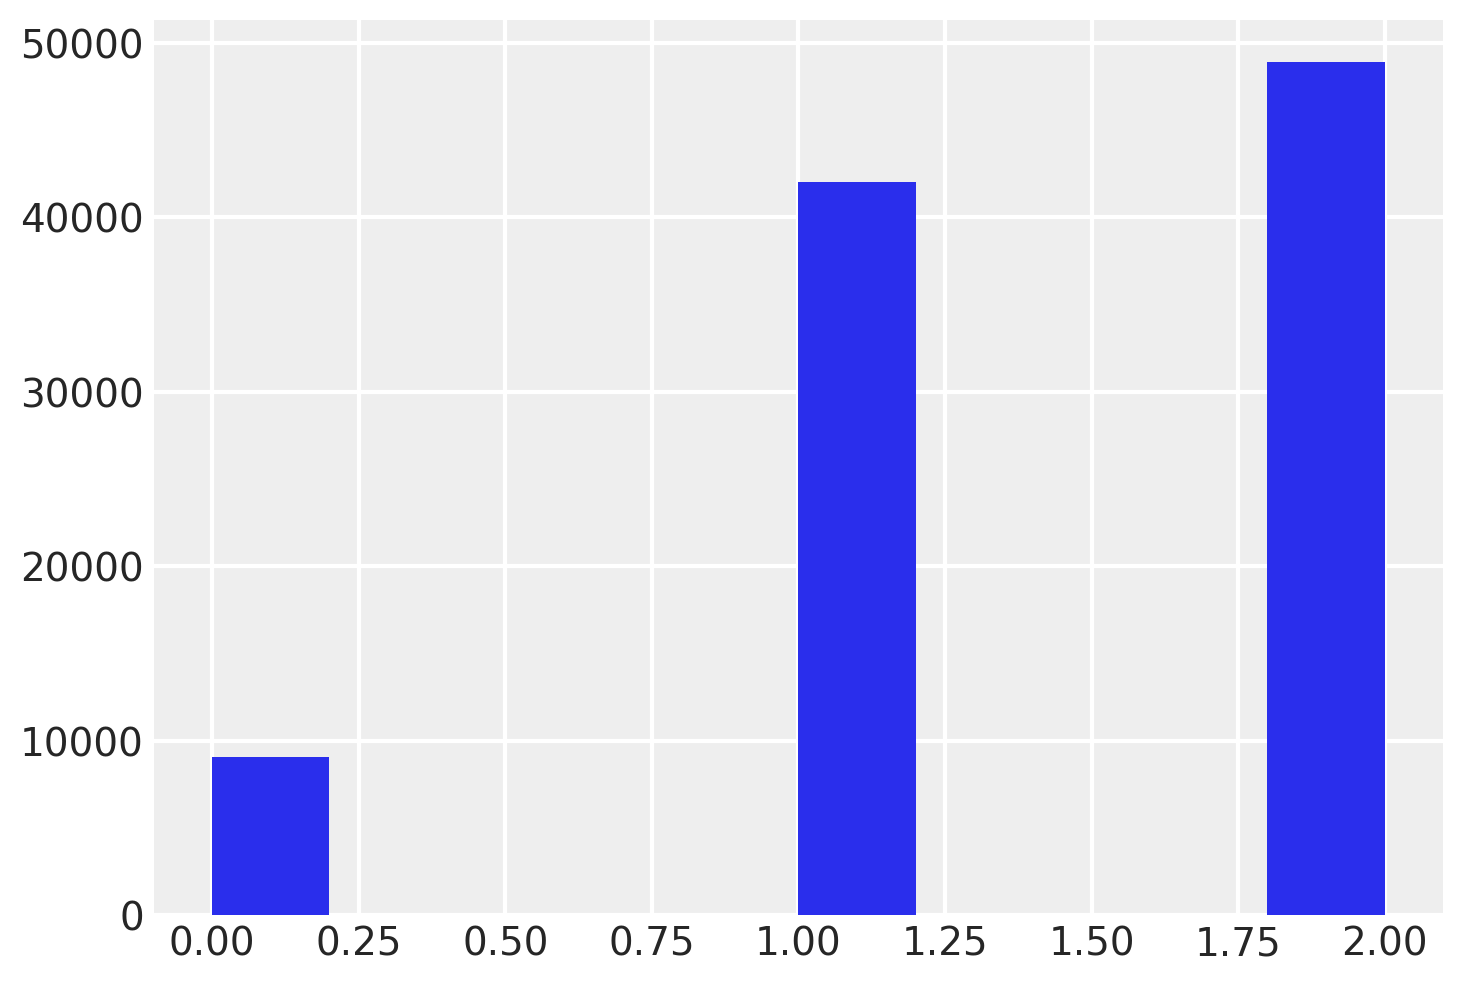

<IPython.core.display.Javascript object>

In [105]:
plt.hist(dummy_w)

### Simulation with `pymc`

The package `pymc` has its own prior (and posterior) simulations. We normally use this to specify a model with a prior and likelihood, but even when the 

$$ W \sim \text{Binomial}(n,p) $$
$$ n = 2 $$
$$ p = 0.7 $$

In [160]:
df_tosses = pd.DataFrame({"toss": range(3), "result": [0, 1, 1]})
df_tosses

toss  result
0     0       0
1     1       1
2     2       1

<IPython.core.display.Javascript object>

In [173]:
# For simulation
with pm.Model() as m1:
    
    # likelihood with known parameters
    W = pm.Binomial("W", n=2, p=0.7)
    # sample
    prior_checks = pm.sample_prior_predictive(samples=30)


<IPython.core.display.Javascript object>

In [174]:
prior_checks["W"]

array([1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0,
       2, 1, 2, 1, 1, 2, 1, 0])

<IPython.core.display.Javascript object>

In [175]:
# For inference
with pm.Model() as m1:

    # prior
    p = pm.Beta("p", alpha=2, beta=2)

    # likelihood, input the generated data as observed
    W = pm.Binomial("W", n=2, p=p, observed=prior_checks["W"])

    # sample
    trace_m1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [176]:
az.summary(trace_m1)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
p  0.685  0.057     0.595      0.774      0.001    0.001    1651.0  1651.0   

   ess_bulk  ess_tail  r_hat  
p    1673.0    2835.0    1.0

<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

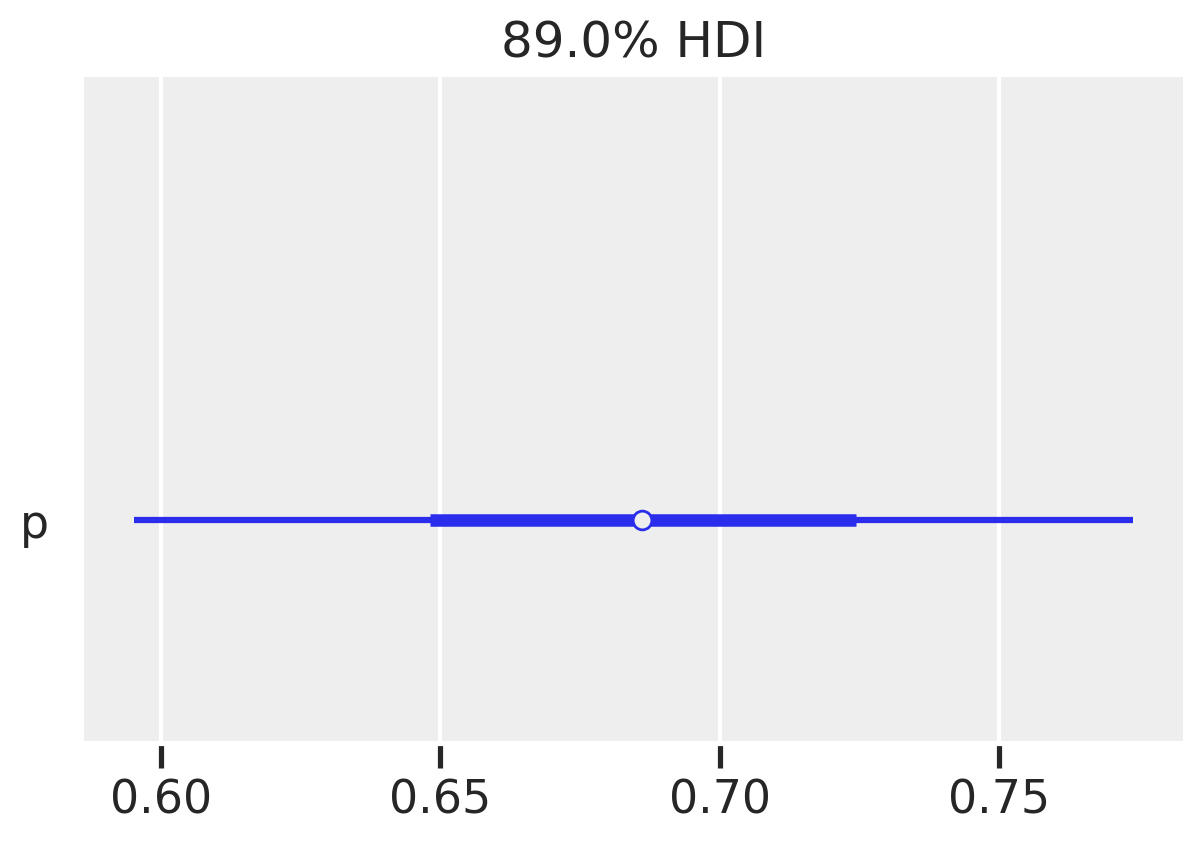

<IPython.core.display.Javascript object>

In [178]:
az.plot_forest(trace_m1, combined=True)

In [181]:
sm.GLM(prior_checks["W"], range(30), family=sm.families.Binomial())

ValueError: unrecognized data structures: <class 'numpy.ndarray'> / <class 'range'>

<IPython.core.display.Javascript object>

Give $n$ a distribution. Want something bounded by zero or positive. Gamma distribution will work.

In [204]:
stats.gamma.rvs(2, size=100).mean()

1.84225689439146

<IPython.core.display.Javascript object>

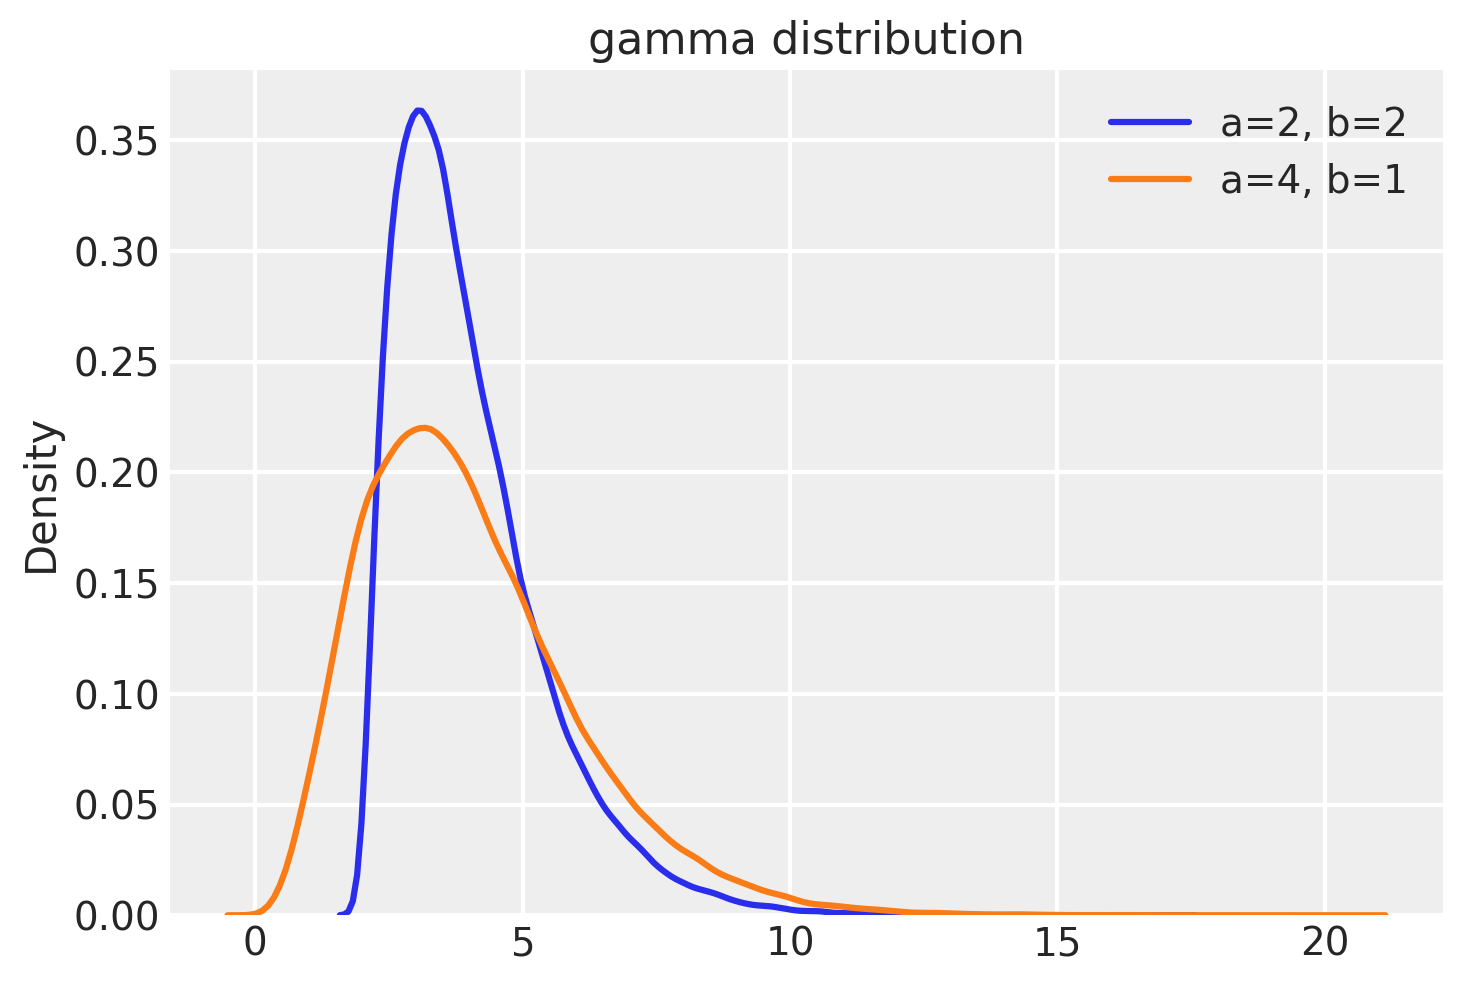

<IPython.core.display.Javascript object>

In [156]:
f, ax1 = plt.subplots()
sns.kdeplot(stats.gamma.rvs(2, 2, size=10**5), ax=ax1, label='a=2, b=2')
sns.kdeplot(stats.gamma.rvs(4, size=10**5), ax=ax1, label='a=4, b=1')    # default scale is 1 (1/b)
ax1.set_title('gamma distribution')
ax1.legend()

(array([37., 21., 17., 12.,  4.,  4.,  1.,  2.,  1.,  1.]),
 array([4.00471553, 4.43040663, 4.85609774, 5.28178884, 5.70747995,
        6.13317105, 6.55886216, 6.98455326, 7.41024437, 7.83593547,
        8.26162658]),
 <BarContainer object of 10 artists>)

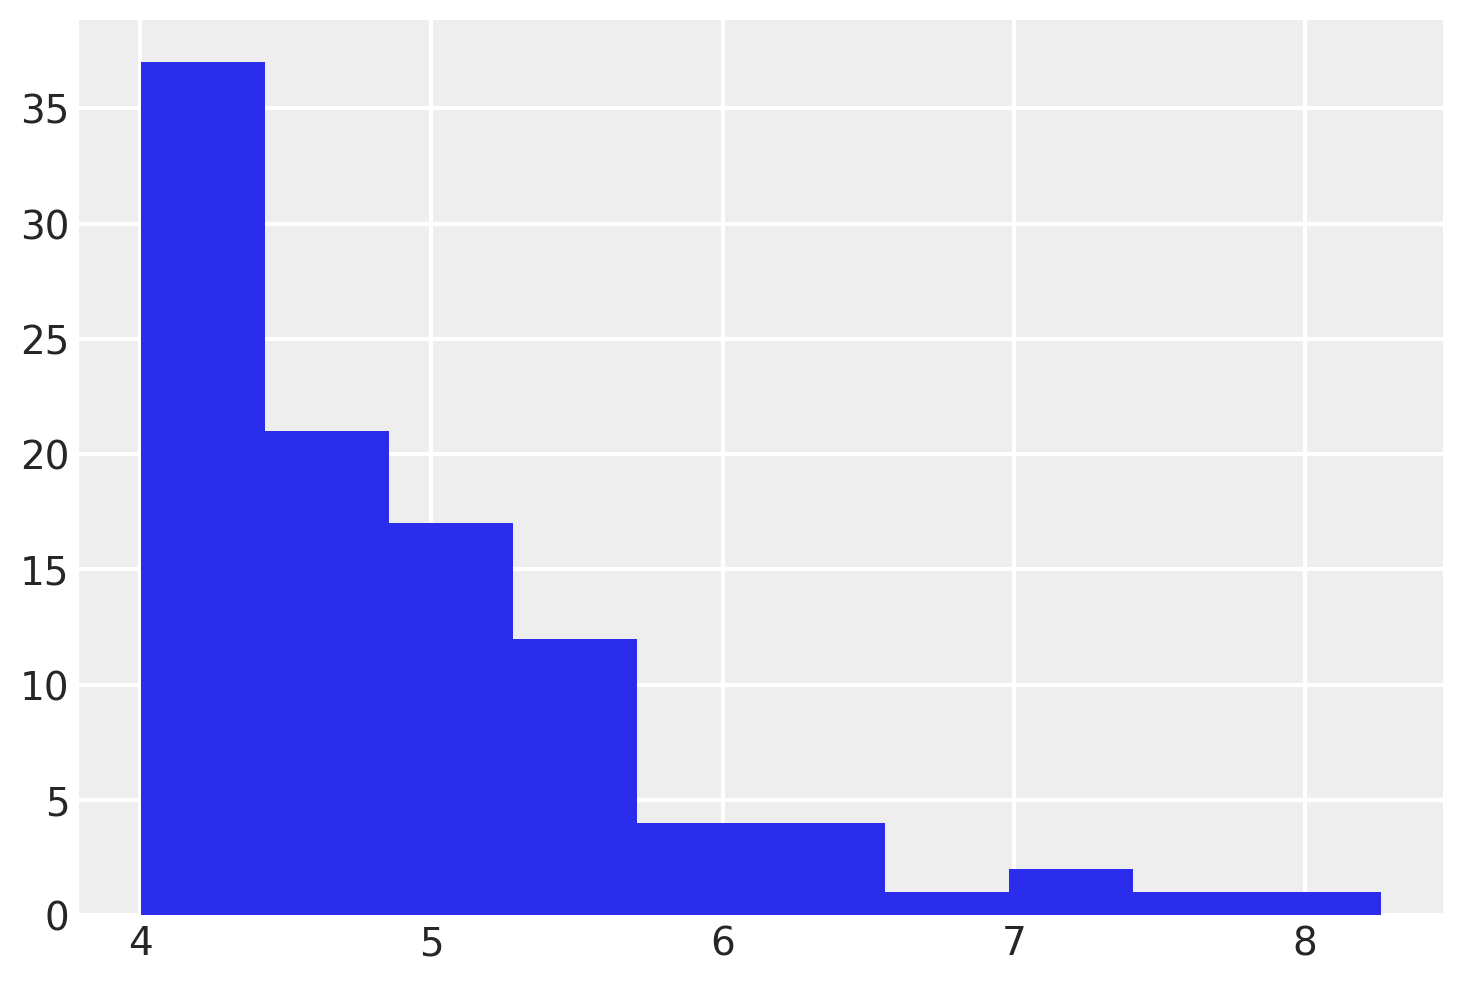

<IPython.core.display.Javascript object>

In [113]:
plt.hist(stats.expon.rvs(4, size=100))

(array([7., 2., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 0.26605083,  6.92597984, 13.58590884, 20.24583784, 26.90576684,
        33.56569585, 40.22562485, 46.88555385, 53.54548285, 60.20541186,
        66.86534086]),
 <BarContainer object of 10 artists>)

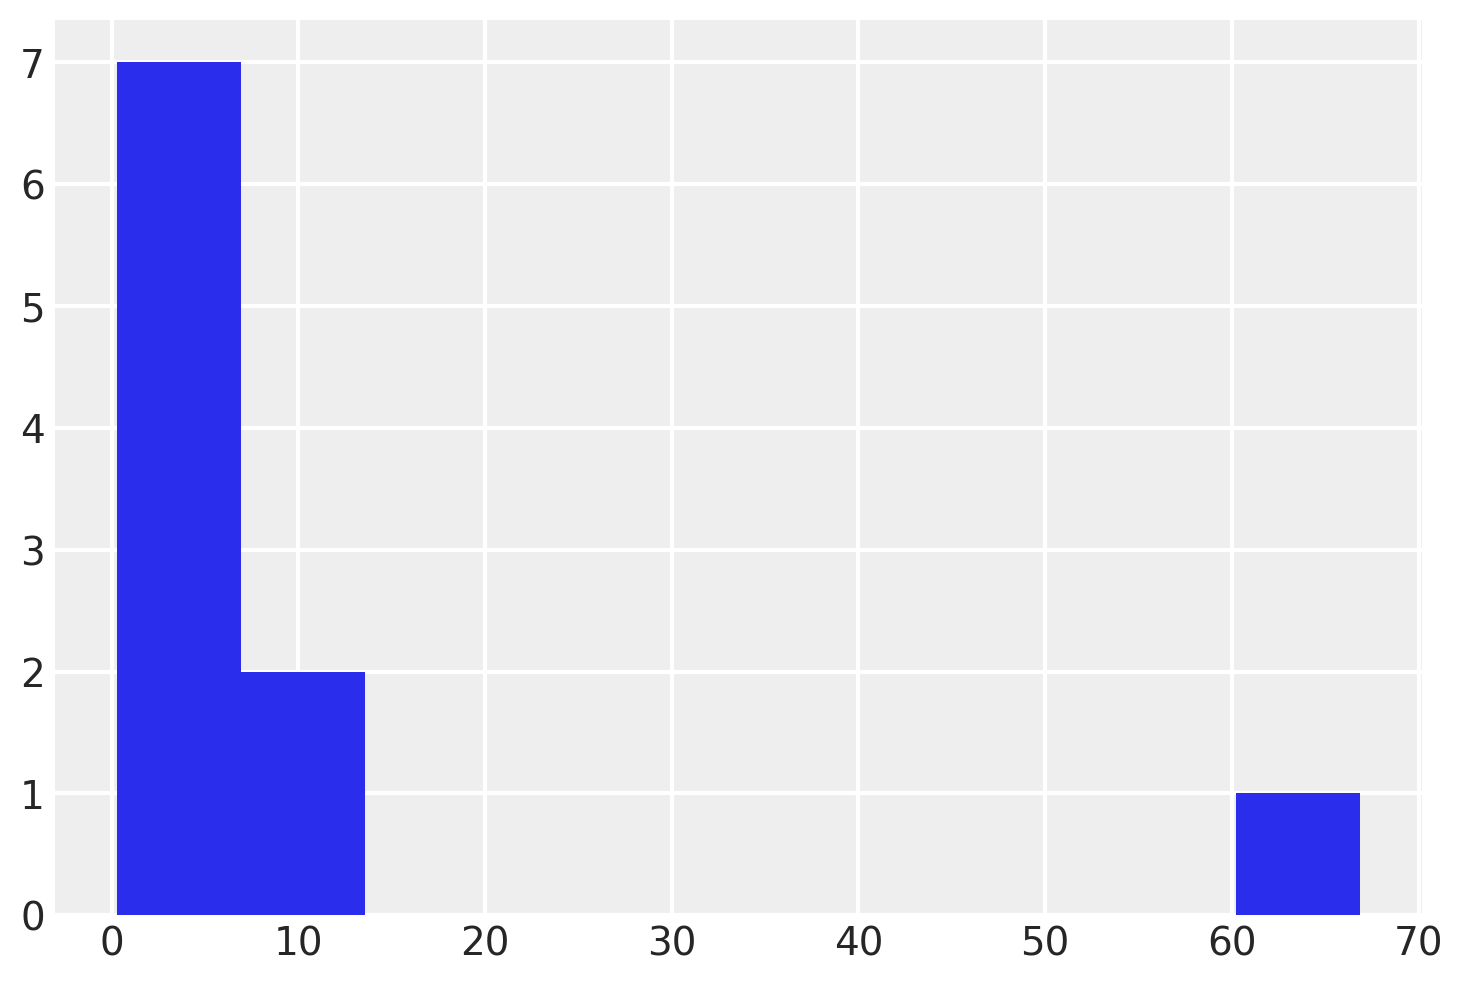

<IPython.core.display.Javascript object>

In [108]:
plt.hist(stats.lognorm.rvs(2, 0.25, size=10))


In [71]:
np.exp(-100)

3.720075976020836e-44

<IPython.core.display.Javascript object>

In [195]:
with pm.Model() as m2:

    # prior
    # n = pm.Gamma("n", alpha=2, beta=2)
    p = pm.Beta("p", alpha=2, beta=2)

    # likelihood
    W = pm.Binomial("W", n=2, p=p)

    # sample
    trace_m2 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)
    prior_checks = pm.sample_prior_predictive(samples=10**5)

prior_checks['W'][0:10]
pd.Series(prior_checks['W']).value_counts() / 10**5

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [p]
INFO:pymc3:>NUTS: [p]
>Metropolis: [W]
INFO:pymc3:>Metropolis: [W]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


1    0.40024
0    0.30035
2    0.29941
dtype: float64

<IPython.core.display.Javascript object>

1    0.39859
0    0.30232
2    0.29909
dtype: float64

<IPython.core.display.Javascript object>

## Linear model with DAG

Now let's try to level up and do simulations based on a DAG.

Categorical variables (treatment or not, fungus or not)

h0 --> h1 <-- F <-- T

Let's imagine that final height is our variable of interest.

In [3]:
# number of plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(10, 2, size=N)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = stats.binom.rvs(n=1, p=0.5 - treatment*0.4, size=N)

# generate projected heights
h1 = h0 + stats.norm.rvs(5 - 3 * fungus, size=N) # default scale parameter is 1

<IPython.core.display.Javascript object>

In [4]:
df_sim_plants = pd.DataFrame(
        {"h0":h0,
        "h1":h1,
        "T":treatment,
        "F":fungus}
    )

df_sim_plants.head()

h0         h1  T  F
0   9.417136  13.263214  0  1
1   7.459338   9.471512  0  1
2  11.839598  17.719684  0  0
3  14.588947  19.582066  0  0
4   9.322042  13.225175  0  0

<IPython.core.display.Javascript object>

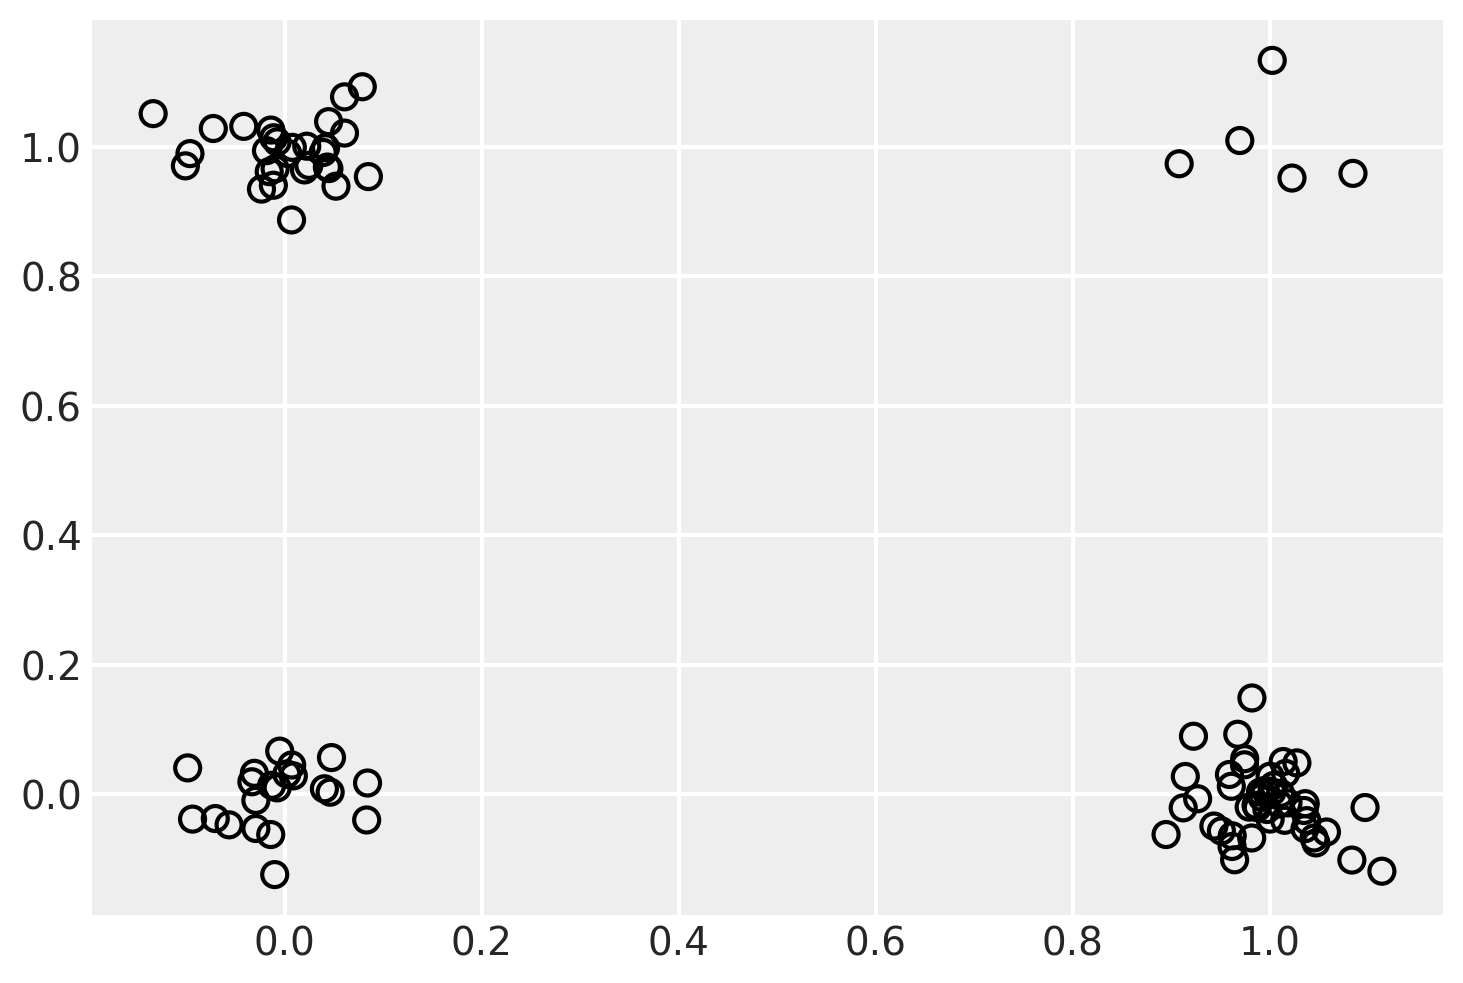

<IPython.core.display.Javascript object>

In [15]:
x_jitter = np.random.normal(0, 0.05, size=len(df_sim_plants))
y_jitter = np.random.normal(0, 0.05, size=len(df_sim_plants))
f, ax1 = plt.subplots()
ax1.scatter(
    df_sim_plants['T'] + x_jitter,
    df_sim_plants['F'] + y_jitter,
    facecolors='none',
    edgecolors='k'
)

In [5]:
az.summary(df_sim_plants.to_dict(orient="list"), kind="stats", round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%
h0   9.82  1.89      5.35      11.84
h1  13.81  2.24      9.47      16.63
T    0.50  0.50      0.00       1.00
F    0.34  0.48      0.00       1.00

<IPython.core.display.Javascript object>

Feed data back into a model. First, use proportions because we don't know absolute height.

Will reference variables by dataframe since that's how we'd get our data.

In [6]:
with pm.Model() as m3:
    
    # priors
    p = pm.Lognormal("p", 0, 0.25) 
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = p*df_sim_plants['h0']

    # likelihood
    h1 = pm.Normal("h1", mu, sigma, observed=df_sim_plants['h1'])

    # prior predictive checks
    prior_checks_m3 = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m3 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


<IPython.core.display.Javascript object>

We can look at the prior predictive simulation to determine the range of how we expect height to change.

In [7]:
az.summary(prior_checks_m3['p'])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
x  1.033  0.264     0.625      1.425      0.001    0.001   97869.0  97869.0   

   ess_bulk  ess_tail  r_hat  
x   97828.0   99658.0    NaN

<IPython.core.display.Javascript object>

We can look at the highest probability density interval and say that the height of the plant may shrink to ~60% of its original height or grow to just over 40% of its original height. Remember that this is just based off the priors.

Now let's actually take a look at how the data changes our predictions.

In [256]:
az.summary(trace_m3)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
p      1.421  0.018     1.394      1.449      0.000    0.000    3886.0   
sigma  1.764  0.126     1.570      1.969      0.002    0.001    3712.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
p      3886.0    3895.0    2896.0    1.0  
sigma  3650.0    3780.0    2534.0    1.0

<IPython.core.display.Javascript object>

Here, we're more confident that the range is around 40% growth. Now let's actually take into account information from the DAG.

In [ ]:
with pm.Model() as m4:
    
    # priors
    p = pm.Lognormal("p", 0, 0.25) 
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = p*df_sim_plants['h0']

    # likelihood
    h1 = pm.Normal("h1", mu, sigma, observed=df_sim_plants['h1'])

    # prior predictive checks
    prior_checks_m4 = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m4 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

In [58]:
prior_checks_m4

NameError: name 'prior_checks_m4' is not defined

<IPython.core.display.Javascript object>

# 15M1

Using the mathematical form of the imputation model in the chapter, explain what is being
assumed about how the missing values were generated.

It depends on the DAG.

- missing completely at random doesn't change the overall distribution (nothing points to missingness)
- missing at random (missigness confounds but can be corrected?)
- missing not at random (missingess confounds but can't be corrected?)

# 15M2

Reconsider the primate milk missing data example from the chapter. This time, assign B a
distribution that is properly bounded between zero and 1. A beta distribution, for example, is a good
choice.

## Original model

$$ K_i \sim \text{Normal}(\mu_i, \sigma) \tag{distribution for outcome K} $$
$$ \mu_i = \alpha + \beta_B B_i + \beta_M \text{log}(M_i) \tag{linear model} $$
$$ B_i \sim \text{Normal}(\nu, \sigma_B) \tag{distribution for obs/missing B} $$
$$ \alpha \sim \text{Normal}(0, 0.5) $$
$$ \beta_B \sim \text{Normal}(0, 0.5) $$
$$ \beta_M \sim \text{Normal}(0, 0.5) $$
$$ \sigma \sim \text{Exponential}(1) $$
$$ \nu \sim \text{Normal}(0.5, 1) $$
$$ \sigma_B \sim \text{Exponential}(1) $$


The text acknowledges that the prior for $B_i$ is imperfect and that the point of the next section is to use a better prior (a beta distribution).

In [29]:
DATA = "/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking/Data/"
df_primates = pd.read_csv(DATA + "milk.csv", sep=";")
df_primates.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

<IPython.core.display.Javascript object>

In [38]:
# Check neocortex missing values
print(f"Number of missing values: ", df_primates["neocortex.perc"].isna().sum())

Number of missing values:  12


<IPython.core.display.Javascript object>

In [47]:
df_primates["neocortex_prop"] = df_primates["neocortex.perc"] / 100
df_primates["neocortex_prop_std"] = standardize(df_primates["neocortex_prop"])
df_primates["k_std"] = standardize(df_primates["kcal.per.g"])
df_primates["logmass"] = np.log(df_primates["mass"])
df_primates["logmass_std"] = standardize(df_primates["logmass"])

<IPython.core.display.Javascript object>

In [37]:
df_primates.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc     k_std     m_std  neocortex_prop  \
0         67.98  1.95           55.16 -0.956680 -0.524942          0.5516   
1         63.82  2.09             NaN -0.830572 -0.519190             NaN   
2         69.04  2.51             NaN -1.145842 -0.501934             NaN   
3         71.91  1.62             NaN -1.019734 -0.538500             NaN   
4         53.22  2.19             NaN -0.263087 -0.515081             NaN   

    logmass  logmass_std  
0  0.667829    -0.463904  
1  0.737164    -0.422348  
2  0.920283    -0.312595  
3  0.482426    -0.575027  
4  0.783902    -0.394336

<IPython.core.display.Javascript object>

In [48]:
with pm.Model() as m15_5a:

    # hyperpriors
    nu = pm.Normal("nu", 0, 0.5)
    sigma_B = pm.Exponential("sigma_B", 1)

    # priors
    a = pm.Normal("a", 0, 0.5)
    bB = pm.Normal("bB", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    # obs/imputed B
    Bi = pm.Normal("Bi", nu, sigma_B, observed=df_primates["neocortex_prop_std"])

    # linear model
    mu = a + bB * Bi + bM * df_primates["logmass_std"]

    # likelihood
    K = pm.Normal("K", mu, sigma, observed=df_primates["k_std"])

    # sample
    trace_m15_5a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/model.py:1739: ImputationWarning: Data in Bi contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bi_missing, sigma, bM, bB, a, sigma_B, nu]
INFO:pymc3:NUTS: [Bi_missing, sigma, bM, bB, a, sigma_B, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

In [49]:
az.summary(trace_m15_5a)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
nu             -0.052  0.215    -0.362      0.316      0.004    0.003   
a               0.031  0.167    -0.211      0.316      0.002    0.003   
bB              0.489  0.239     0.112      0.877      0.006    0.004   
bM             -0.548  0.206    -0.871     -0.225      0.004    0.003   
Bi_missing[0]  -0.590  0.969    -2.146      0.868      0.014    0.014   
Bi_missing[1]  -0.736  0.970    -2.256      0.776      0.016    0.012   
Bi_missing[2]  -0.760  0.991    -2.177      1.012      0.015    0.014   
Bi_missing[3]  -0.287  0.928    -1.898      1.069      0.013    0.014   
Bi_missing[4]   0.474  0.972    -1.051      1.992      0.013    0.015   
Bi_missing[5]  -0.183  0.928    -1.557      1.408      0.014    0.015   
Bi_missing[6]   0.201  0.903    -1.250      1.616      0.012    0.015   
Bi_missing[7]   0.279  0.936    -1.087      1.845      0.012    0.016   
Bi_missing[8]   0.522  0.960    -0.926      2.129      0.013    0.013   
Bi_missing[9]  -0.461  0.938    -1.900      1.064      0.013    0.014   
Bi_missing[10] -0.292  0.917    -1.740      1.162      0.013    0.015   
Bi_missing[11]  0.150  0.935    -1.334      1.615      0.012    0.016   
sigma_B         1.045  0.179     0.773      1.303      0.003    0.002   
sigma           0.855  0.146     0.631      1.075      0.003    0.002   

                ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
nu                3639.0  2312.0    3617.0    3015.0    1.0  
a                 5023.0  1787.0    5033.0    2679.0    1.0  
bB                1843.0  1829.0    1836.0    2669.0    1.0  
bM                2719.0  2594.0    2698.0    2570.0    1.0  
Bi_missing[0]     4815.0  2423.0    4873.0    2953.0    1.0  
Bi_missing[1]     3769.0  3068.0    3828.0    2655.0    1.0  
Bi_missing[2]     4220.0  2643.0    4255.0    2823.0    1.0  
Bi_missing[3]     4812.0  2072.0    4777.0    2880.0    1.0  
Bi_missing[4]     5488.0  2188.0    5554.0    2965.0    1.0  
Bi_missing[5]     4595.0  1938.0    4594.0    3008.0    1.0  
Bi_missing[6]     6154.0  1730.0    6105.0    2772.0    1.0  
Bi_missing[7]     5753.0  1782.0    5885.0    2482.0    1.0  
Bi_missing[8]     5342.0  2601.0    5358.0    3190.0    1.0  
Bi_missing[9]     5542.0  2327.0    5415.0    2828.0    1.0  
Bi_missing[10]    5084.0  1972.0    5235.0    2505.0    1.0  
Bi_missing[11]    5863.0  1645.0    5912.0    2977.0    1.0  
sigma_B           3104.0  2939.0    3350.0    2923.0    1.0  
sigma             2195.0  2195.0    1966.0    2180.0    1.0

<IPython.core.display.Javascript object>

Cool! Posterior distributions are imputed for the missing values.

## Model with beta distribution

Here, we can place a beta distribution prior for B and use hyperpriors for its parameters. Traditionally, a beta distribution is referred to as alpha and beta, but I'll call them delta and gamma here since we're already using those Greek letters.

$$ K_i \sim \text{Normal}(\mu_i, \sigma) \tag{distribution for outcome K} $$
$$ \mu_i = \alpha + \beta_B B_i + \beta_M \text{log}(M_i) \tag{linear model} $$
$$ B_i \sim \text{Beta}(\delta, \gamma) \tag{distribution for obs/missing B} $$
$$ \alpha \sim \text{Normal}(0, 0.5) $$
$$ \beta_B \sim \text{Normal}(0, 0.5) $$
$$ \beta_M \sim \text{Normal}(0, 0.5) $$
$$ \sigma \sim \text{Exponential}(1) $$
$$ \delta \sim \text{HalfNormal}(0.5) $$
$$ \gamma \sim \text{HalfNormal}(0.5) $$

mu value:  0.5


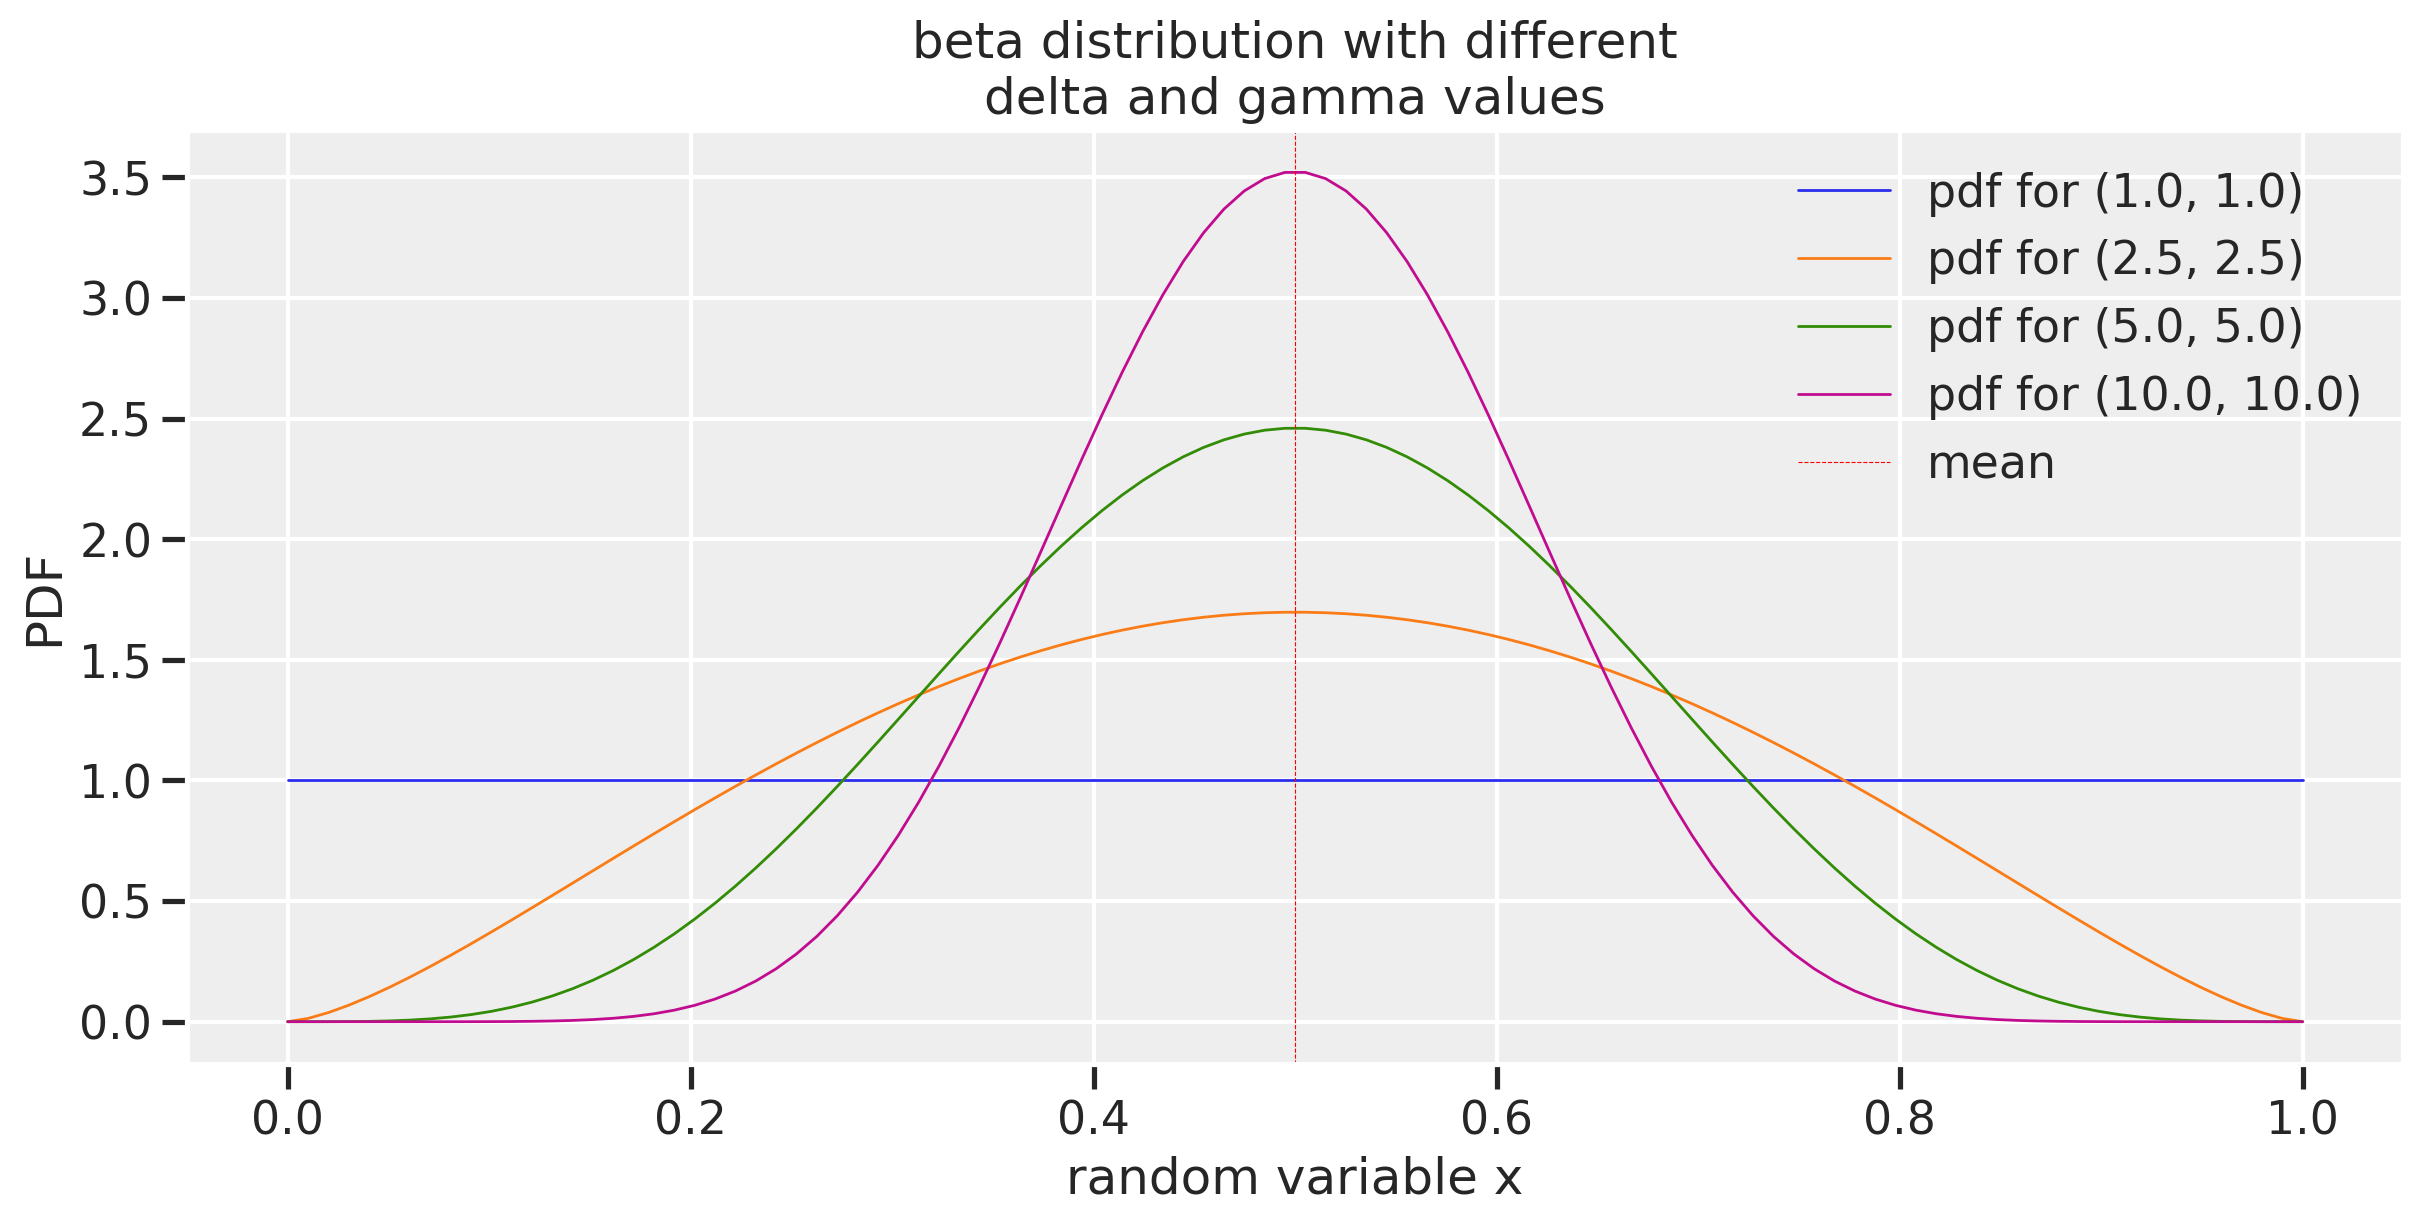

<IPython.core.display.Javascript object>

In [42]:
from scipy.stats import beta

# mu is the midpoint of the distribution
mu = 0.5
print("mu value: ", mu)

# Generate different values of alpha (a) and beta (b)
n_list = [2, 5, 10, 20]

f, ax1 = plt.subplots(figsize=(12, 6))
for n in n_list:
    a = mu * n
    b = n - a

    x = np.linspace(beta.ppf(0.00, a, b), beta.ppf(1.00, a, b), 100)
    this_label = "pdf for (" + str(a) + ", " + str(b) + ")"

    ax1.plot(x, beta.pdf(x, a, b), lw=1, label=this_label)

ax1.axvline(mu, lw=0.4, color="red", linestyle="dashed", label="mean")
ax1.set_title("beta distribution with different\ndelta and gamma values")
ax1.set_xlabel("random variable x")
ax1.set_ylabel("PDF")
ax1.legend()

Had issues getting this to work properly. Had to look at the answer solutions to see that there were tricks to get this working right.

In [55]:
with pm.Model() as m15_5b:

    # hyperpriors
    #     delta = pm.HalfNormal("delta", 0.1)
    #     gamma = pm.HalfNormal("gamma", 0.1)

    # priors
    a = pm.Normal("a", 0, 0.5)
    bB = pm.Normal("bB", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    # obs/imputed B with beta distribution (avoid standardizing)
    # Bi = pm.Beta("Bi", delta, gamma, observed=df_primates["neocortex_prop"])
    Bi = pm.Beta("Bi", alpha=1, beta=1, observed=df_primates["neocortex_prop"])

    # linear model
    mu = a + bB * (Bi - 0.67) + bM * df_primates["logmass_std"]

    # likelihood
    K = pm.Normal("K", mu, sigma, observed=df_primates["k_std"])

    # sample
    trace_m15_5b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/model.py:1739: ImputationWarning: Data in Bi contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'a': array(-0.80057862), 'bB': array(0.31003719), 'bM': array(0.06270603), 'sigma_log__': array(-1.31484483), 'Bi_missing': array([ 1.42181326,  1.29176305,  0.89386098,  1.39275087,  0.14458384,
       -0.39778831,  0.79556126, -0.09505109,  0.84795039,  0.27948074,
        0.02310535,  0.13706759])}

Initial evaluation results:
a               -1.51
bB              -0.42
bM              -0.23
sigma_log__     -1.58
Bi_missing       0.00
Bi               -inf
K             -342.50
Name: Log-probability of test_point, dtype: float64

<IPython.core.display.Javascript object>

## Model with alternate beta

In [93]:
# why does answer key subtract -0.67
df_primates["neocortex_prop"].mean()

0.6757588235294119

<IPython.core.display.Javascript object>

In [97]:
with pm.Model() as m15_5c:

    # hyperpriors
    nu = pm.Beta("nu", alpha=2, beta=2)
    theta = pm.Exponential("theta", 1)

    # priors
    a = pm.Normal("a", 0, 0.5)
    bB = pm.Normal("bB", 0, 10)  # its so flat because it's a proportion now
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    # obs/imputed B with beta distribution (avoid standardizing)
    Bi = pm.Beta("Bi", mu=nu, sigma=theta, observed=df_primates["neocortex_prop"])

    # linear model
    mu = (
        a
        + bB * (Bi - df_primates["neocortex_prop"].mean())
        + bM * df_primates["logmass_std"]
    )

    # likelihood
    K = pm.Normal("K", mu, sigma, observed=df_primates["k_std"])

    # sample
    trace_m15_5c = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/model.py:1739: ImputationWarning: Data in Bi contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'nu_logodds__': array(0.), 'theta_log__': array(-0.36651292), 'a': array(0.), 'bB': array(0.), 'bM': array(0.), 'sigma_log__': array(-0.36651292), 'Bi_missing': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])}

Initial evaluation results:
nu_logodds__    -0.98
theta_log__     -1.06
a               -0.23
bB              -3.22
bM              -0.23
sigma_log__     -1.06
Bi_missing       0.00
Bi               -inf
K              -46.20
Name: Log-probability of test_point, dtype: float64

<IPython.core.display.Javascript object>

# 15M3

Repeat the divorce data measurement error models, but this time double the standard errors. Can you explain how doubling the standard errors impacts inference?

Why 
```
D_sd = d$Divorce.SE / sd( d$Divorce )
```
Make sure standard error is on same scale of divorce.

Standardize divorce so also need to standardize the standard error.


In [59]:
DATA = "/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking/Data/"
df_divorce = pd.read_csv(DATA + "WaffleDivorce.csv", sep=";")
df_divorce["2_Divorce SE"] = 2 * df_divorce["Divorce SE"]
df_divorce.head()

Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
0     Alabama  AL        4.78               25.3      20.2         1.27   
1      Alaska  AK        0.71               25.2      26.0         2.93   
2     Arizona  AZ        6.33               25.8      20.3         0.98   
3    Arkansas  AR        2.92               24.3      26.4         1.70   
4  California  CA       37.25               26.8      19.1         0.39   

   Divorce  Divorce SE  WaffleHouses  South  Slaves1860  Population1860  \
0     12.7        0.79           128      1      435080          964201   
1     12.5        2.05             0      0           0               0   
2     10.8        0.74            18      0           0               0   
3     13.5        1.22            41      1      111115          435450   
4      8.0        0.24             0      0           0          379994   

   PropSlaves1860  2_Divorce SE  
0            0.45          1.58  
1            0.00          4.10  
2            0.00          1.48  
3            0.26          2.44  
4            0.00          0.48

<IPython.core.display.Javascript object>

Text(0.5, 1.0, '2 x Original SE')

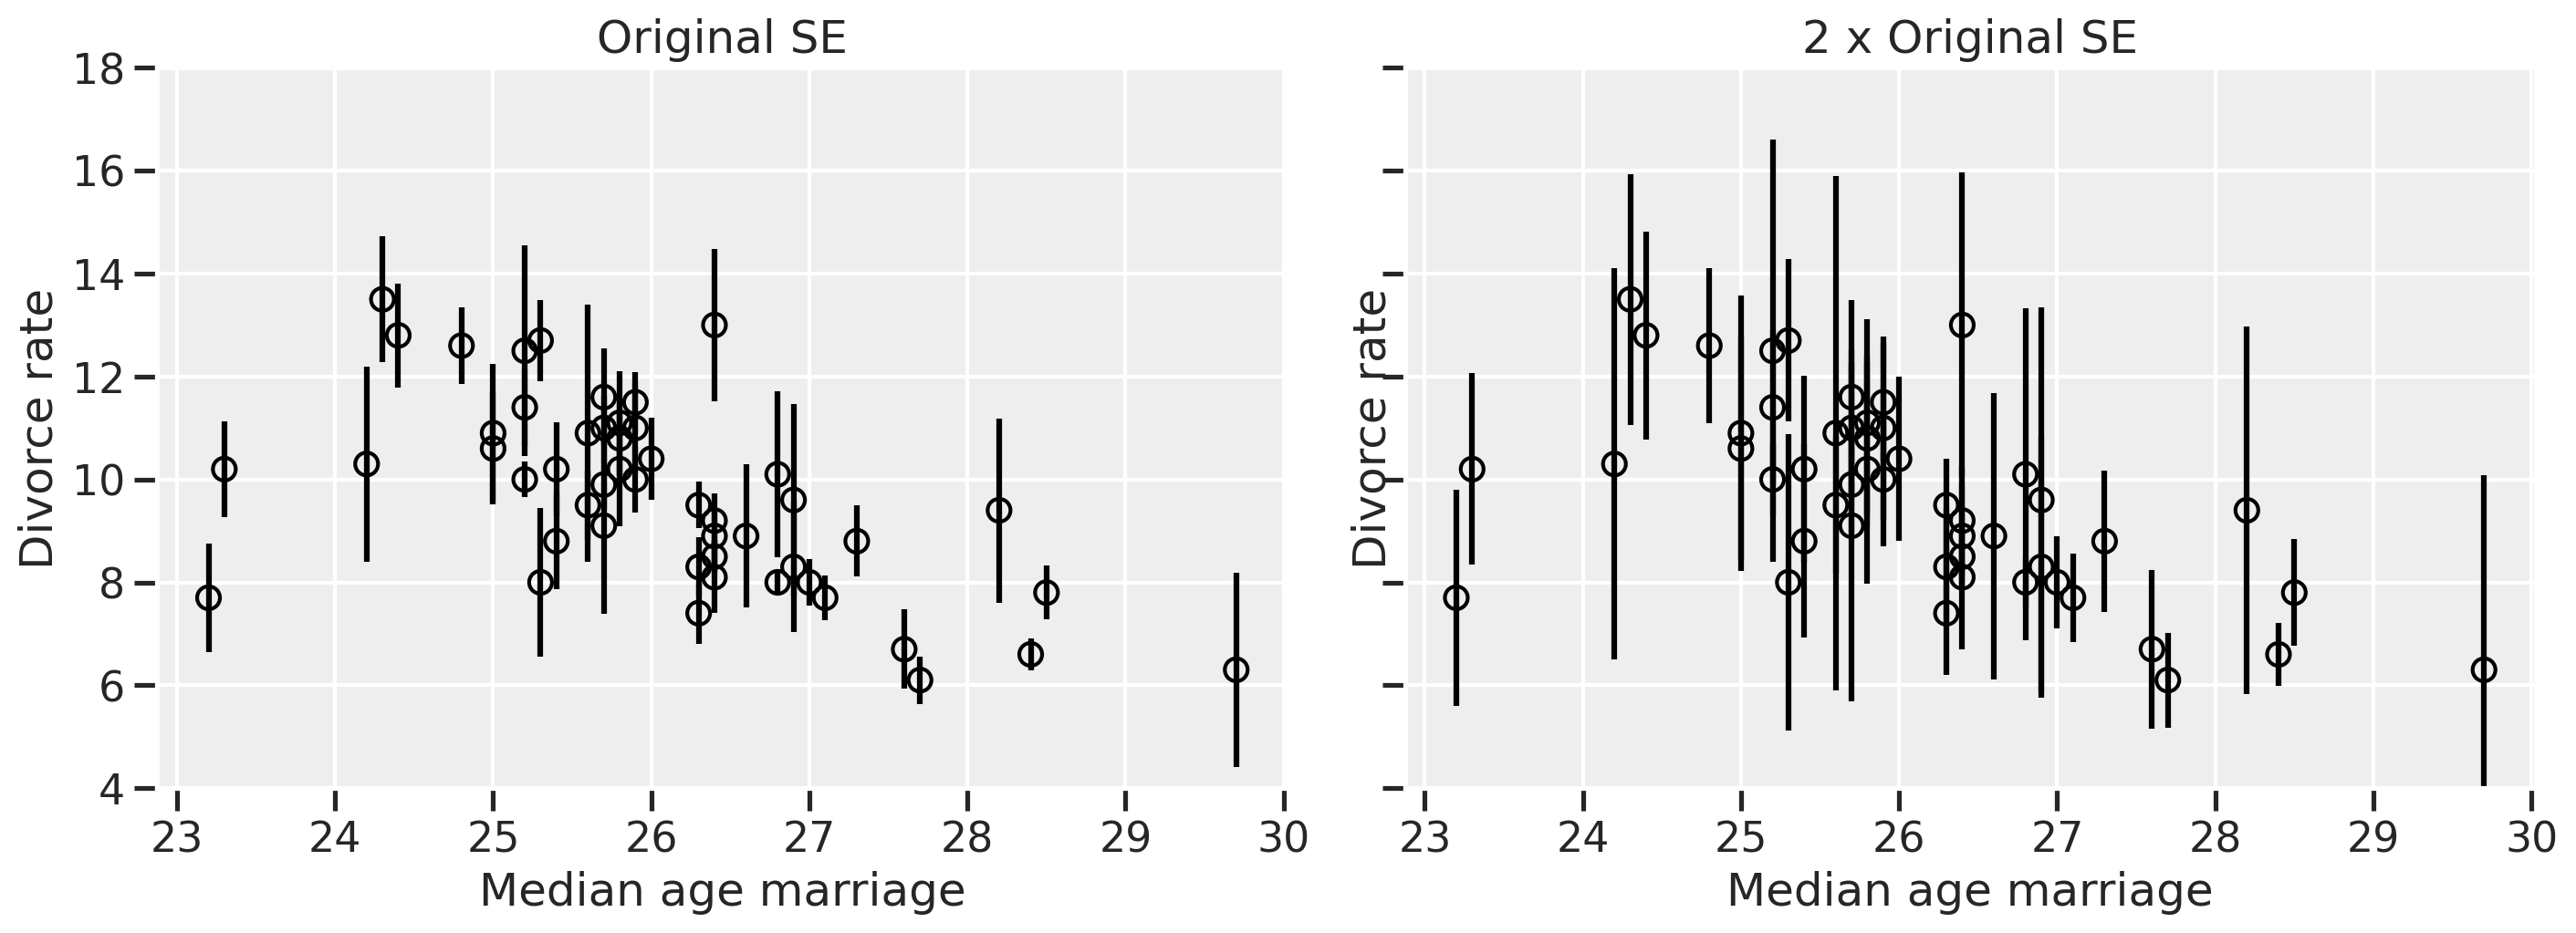

<IPython.core.display.Javascript object>

In [64]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
# first plot, code from repo
ax.scatter(
    df_divorce["MedianAgeMarriage"],
    df_divorce["Divorce"],
    edgecolor="k",
    facecolor="none",
)
ax.errorbar(
    df_divorce["MedianAgeMarriage"],
    df_divorce["Divorce"],
    yerr=df_divorce["Divorce SE"],
    fmt="none",
    c="k",
)

ax.set_ylim(4, 18)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate")
ax.set_title("Original SE")

# second plot
ax2.scatter(
    df_divorce["MedianAgeMarriage"],
    df_divorce["Divorce"],
    edgecolor="k",
    facecolor="none",
)
ax2.errorbar(
    df_divorce["MedianAgeMarriage"],
    df_divorce["Divorce"],
    yerr=df_divorce["2_Divorce SE"],
    fmt="none",
    c="k",
)

# ax2.set_ylim(4, 15)
ax2.set_xlabel("Median age marriage")
ax2.set_ylabel("Divorce rate")
ax2.set_title("2 x Original SE")

Recall that we have this model:

$$ D_{\text{OBS,i}} \sim \text{Normal}(D_{\text{TRUE,i}},D_{\text{SE,i}}) \tag{distribution for observed values} $$
$$ \mu_i = \alpha + \beta_AA_i + \beta_MM_i \tag{linear model to assess A → D} $$
$$ \alpha \sim \text{Normal}(0, 0.2) $$
$$ \beta_A \sim \text{Normal}(0, 0.5) $$
$$ \beta_M \sim \text{Normal}(0, 0.5) $$
$$ \sigma \sim \text{Exponential}(1) $$

In [67]:
# pymc repo code (original model)
D_obs = standardize(df_divorce["Divorce"])
D_sd = df_divorce["Divorce SE"] / df_divorce["Divorce"].std()
M = standardize(df_divorce["Marriage"])
A = standardize(df_divorce["MedianAgeMarriage"])
N = len(df_divorce)

with pm.Model() as m15_1:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = a + bA * A + bM * M  # linear model to assess A -> D
    D_true = pm.Normal("D_true", mu, sigma, shape=N)  # distribution for true values
    
    
    # distribution for observed values
    D = pm.Normal(
        "D_obs", D_true, D_sd, observed=D_obs
    )  

    trace_m15_1 = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_true, a, bA, bM, sigma]
INFO:pymc3:NUTS: [D_true, a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [69]:
# pymc repo code with 2 SE
D_obs = standardize(df_divorce["Divorce"])
D_sd = df_divorce["2_Divorce SE"] / df_divorce["Divorce"].std()
M = standardize(df_divorce["Marriage"])
A = standardize(df_divorce["MedianAgeMarriage"])
N = len(df_divorce)

with pm.Model() as m15_1b:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = a + bA * A + bM * M  # linear model to assess A -> D
    D_true = pm.Normal("D_true", mu, sigma, shape=N)  # distribution for true values

    # distribution for observed values
    D = pm.Normal("D_obs", D_true, D_sd, observed=D_obs)

    trace_m15_1b = pm.sample(
        return_inferencedata=True, random_seed=RANDOM_SEED, target_accept=0.95
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_true, a, bA, bM, sigma]
INFO:pymc3:NUTS: [D_true, a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 432 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 432 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5869107984776012, but should be close to 0.95. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8456300766670493, but sh

<IPython.core.display.Javascript object>

- Had to increase `target_accept`

In [92]:
az.summary(trace_m15_1, var_names=["bM", "bA", "a", "sigma"])

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
bM     0.045  0.166    -0.218      0.312      0.004    0.003    1888.0   
bA    -0.619  0.163    -0.875     -0.360      0.004    0.003    1778.0   
a     -0.055  0.096    -0.198      0.105      0.002    0.001    2669.0   
sigma  0.598  0.109     0.436      0.781      0.003    0.002     976.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
bM     1888.0    1891.0    2404.0    1.0  
bA     1778.0    1778.0    2586.0    1.0  
a      2336.0    2677.0    2555.0    1.0  
sigma   976.0     939.0     749.0    1.0

<IPython.core.display.Javascript object>

In [91]:
az.summary(trace_m15_1b, var_names=["bM", "bA", "a", "sigma"])

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
bM     0.213  0.191    -0.082      0.500      0.020    0.014      89.0   
bA    -0.628  0.166    -0.864     -0.358      0.014    0.010     136.0   
a     -0.118  0.094    -0.274      0.028      0.005    0.004     291.0   
sigma  0.146  0.106     0.008      0.298      0.025    0.018      17.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
bM       89.0      80.0     318.0   1.05  
bA      136.0     146.0     447.0   1.04  
a       291.0     277.0     441.0   1.03  
sigma    17.0      15.0      21.0   1.19

<IPython.core.display.Javascript object>

Text(0.5, 1.0, '2 x SE model')

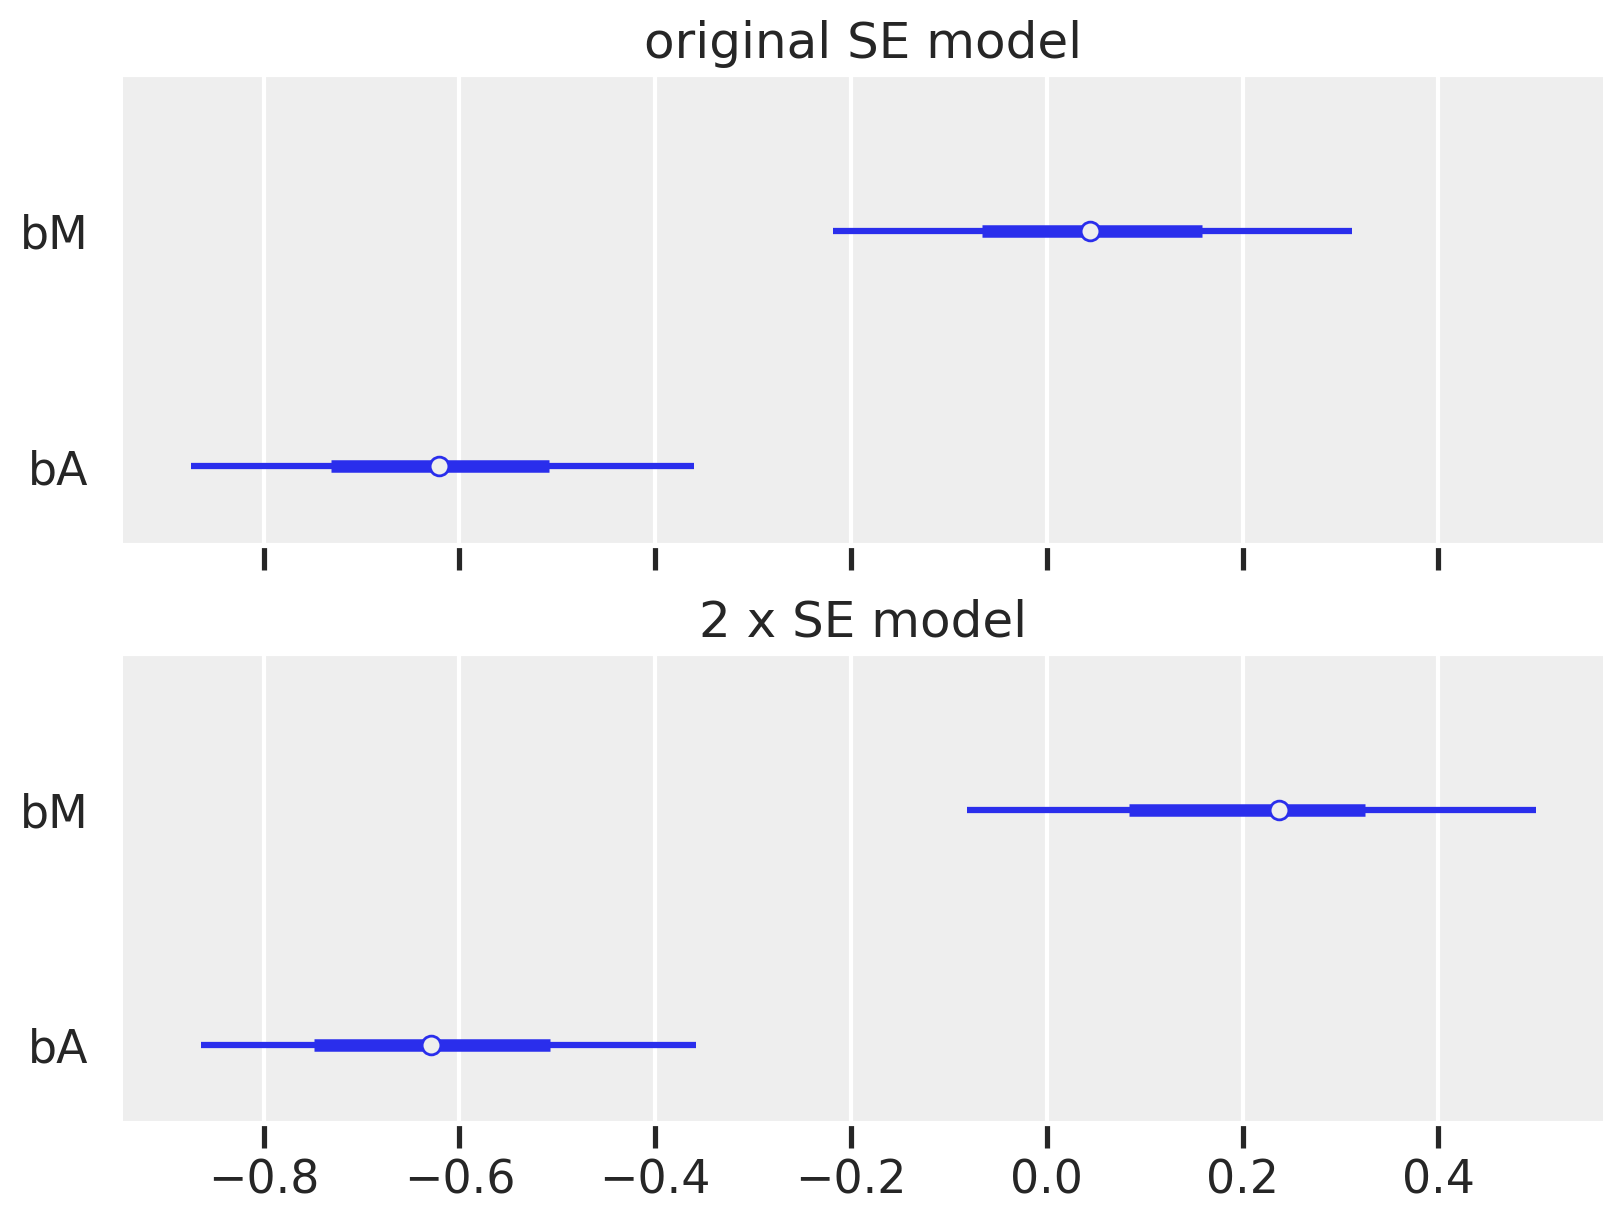

<IPython.core.display.Javascript object>

In [78]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
az.plot_forest(trace_m15_1, var_names=["bM", "bA"], combined=True, ax=ax1)
ax1.set_title("original SE model")

az.plot_forest(trace_m15_1b, var_names=["bM", "bA"], combined=True, ax=ax2)
ax2.set_title("2 x SE model")

## Viewing on the outcome scale

In [102]:
df_divorce.head()

Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
0     Alabama  AL        4.78               25.3      20.2         1.27   
1      Alaska  AK        0.71               25.2      26.0         2.93   
2     Arizona  AZ        6.33               25.8      20.3         0.98   
3    Arkansas  AR        2.92               24.3      26.4         1.70   
4  California  CA       37.25               26.8      19.1         0.39   

   Divorce  Divorce SE  WaffleHouses  South  Slaves1860  Population1860  \
0     12.7        0.79           128      1      435080          964201   
1     12.5        2.05             0      0           0               0   
2     10.8        0.74            18      0           0               0   
3     13.5        1.22            41      1      111115          435450   
4      8.0        0.24             0      0           0          379994   

   PropSlaves1860  2_Divorce SE  
0            0.45          1.58  
1            0.00          4.10  
2            0.00          1.48  
3            0.26          2.44  
4            0.00          0.48

<IPython.core.display.Javascript object>

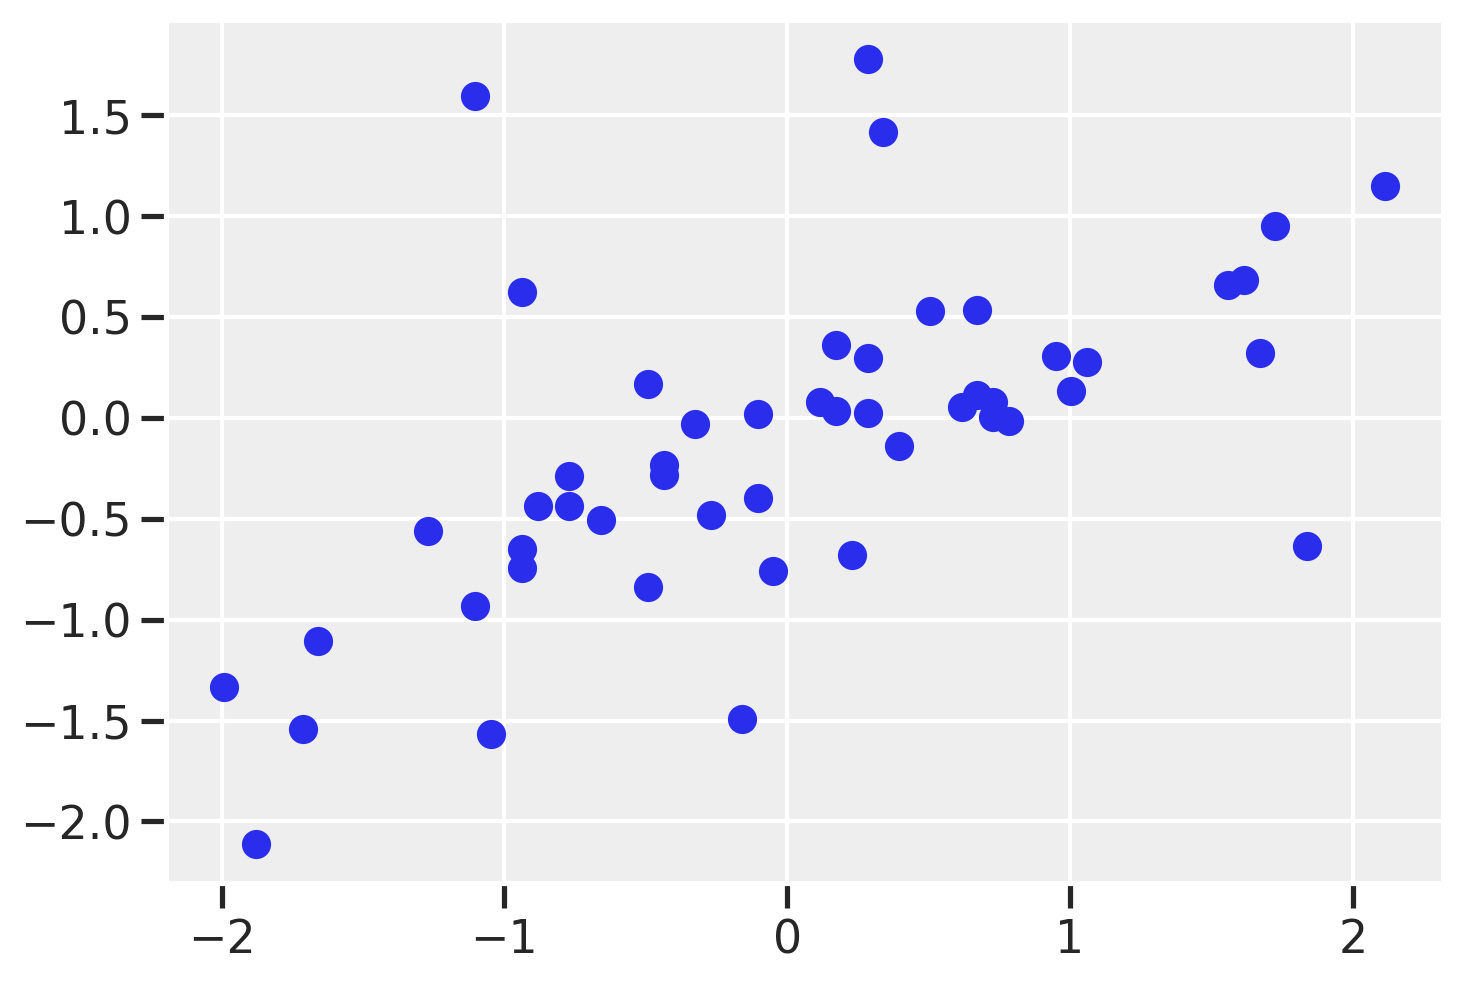

<IPython.core.display.Javascript object>

In [104]:
plt.scatter(D_obs, az.summary(trace_m15_1b, var_names="D_true")["mean"])

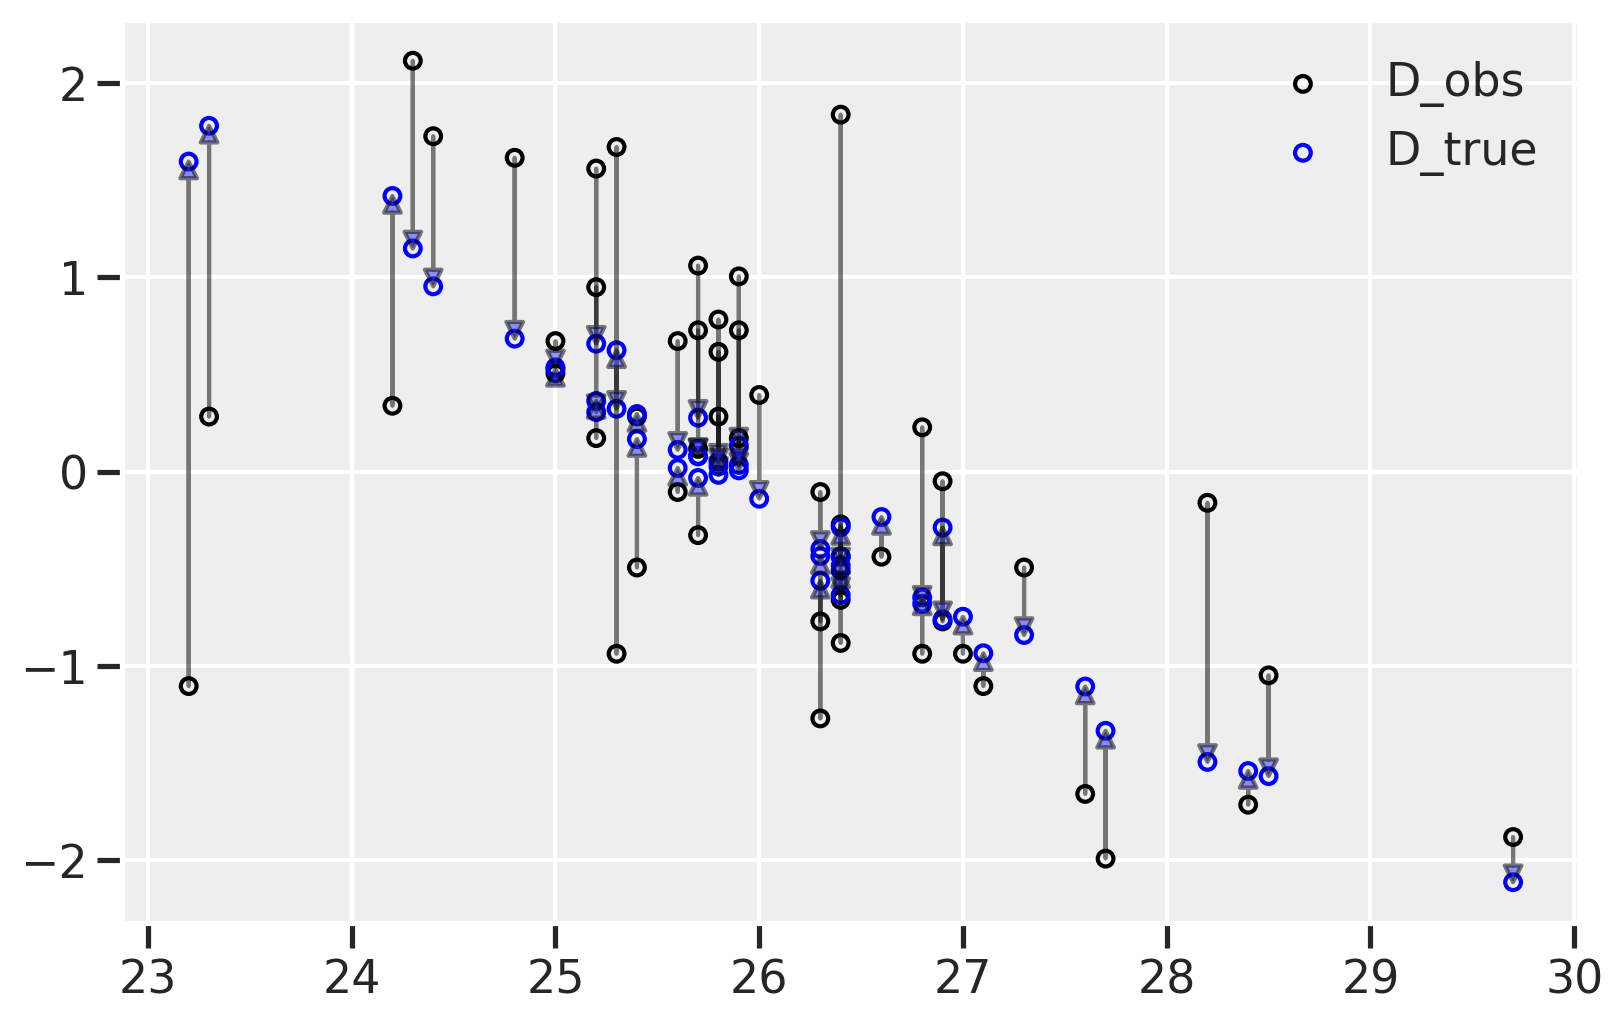

<IPython.core.display.Javascript object>

In [151]:
D_true = az.summary(trace_m15_1b, var_names="D_true")["mean"]

f, ax1 = plt.subplots(1, 1, figsize=(8, 5))
ax1.scatter(
    df_divorce["MedianAgeMarriage"],
    D_obs,
    facecolors="none",
    edgecolors="k",
    s=2 ** 5,
    label="D_obs",
)

ax1.scatter(
    df_divorce["MedianAgeMarriage"],
    D_true,
    facecolors="none",
    edgecolors="blue",
    s=2 ** 5,
    label="D_true",
)

for i in range(len(df_divorce["MedianAgeMarriage"])):
    ax1.annotate(
        "",
        xy=[df_divorce["MedianAgeMarriage"][i], D_true[i]],
        xytext=[df_divorce["MedianAgeMarriage"][i], D_obs[i]],
        # arrowprops=(width=2),
        arrowprops=dict(
            alpha=0.5, width=0.01, headwidth=6, headlength=6, shrink=2
        ),  # arrowstyle="->"),
        # color="gray",
    )
ax1.legend()

# ax1.annotate("", xy=[24, -1], xytext=[24, 0], arrowprops=dict(arrowstyle="->"))
# ax.annotate("", xy=(0.5, 0.5), xytext=(0, 0), arrowprops=dict(arrowstyle="->"))

In [101]:
az.summary(trace_m15_1b)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
bM          0.213  0.191    -0.082      0.500      0.020    0.014      89.0   
bA         -0.628  0.166    -0.864     -0.358      0.014    0.010     136.0   
a          -0.118  0.094    -0.274      0.028      0.005    0.004     291.0   
D_true[0]   0.324  0.218    -0.001      0.649      0.010    0.009     512.0   
D_true[1]   0.659  0.337     0.109      1.198      0.023    0.017     206.0   
D_true[2]   0.052  0.200    -0.239      0.349      0.007    0.008     925.0   
D_true[3]   1.149  0.319     0.651      1.692      0.020    0.014     257.0   
D_true[4]  -0.647  0.181    -0.903     -0.349      0.016    0.011     128.0   
D_true[5]   0.278  0.261    -0.118      0.711      0.017    0.012     228.0   
D_true[6]  -1.105  0.234    -1.455     -0.751      0.013    0.009     341.0   
D_true[7]  -0.233  0.301    -0.729      0.175      0.026    0.019     132.0   
D_true[8]  -2.112  0.464    -2.784     -1.342      0.037    0.026     156.0   
D_true[9]  -0.507  0.174    -0.789     -0.253      0.008    0.007     458.0   
D_true[10]  0.135  0.216    -0.183      0.463      0.011    0.008     360.0   
D_true[11] -0.287  0.399    -0.913      0.291      0.034    0.024     136.0   
D_true[12]  1.596  0.374     1.026      2.239      0.030    0.021     158.0   
D_true[13] -0.746  0.190    -1.075     -0.466      0.009    0.006     467.0   
D_true[14]  0.081  0.201    -0.235      0.376      0.008    0.012     616.0   
D_true[15]  0.297  0.211    -0.009      0.633      0.008    0.006     759.0   
D_true[16]  0.529  0.225     0.202      0.921      0.009    0.006     668.0   
D_true[17]  0.685  0.223     0.343      1.054      0.009    0.007     610.0   
D_true[18]  0.007  0.191    -0.276      0.312      0.006    0.009    1013.0   
D_true[19] -0.634  0.341    -1.129     -0.103      0.033    0.023     108.0   
D_true[20] -0.840  0.220    -1.172     -0.495      0.015    0.010     228.0   
D_true[21] -1.566  0.287    -1.994     -1.064      0.024    0.017     146.0   
D_true[22] -0.482  0.215    -0.814     -0.145      0.014    0.010     238.0   
D_true[23] -0.561  0.253    -0.967     -0.179      0.020    0.014     166.0   
D_true[24] -0.016  0.209    -0.317      0.302      0.006    0.008    1058.0   
D_true[25]  0.019  0.202    -0.278      0.339      0.008    0.011     574.0   
D_true[26] -0.032  0.216    -0.358      0.307      0.009    0.009     598.0   
D_true[27]  0.168  0.213    -0.188      0.468      0.008    0.006     747.0   
D_true[28] -0.679  0.220    -1.044     -0.373      0.011    0.008     407.0   
D_true[29] -1.333  0.232    -1.702     -0.958      0.015    0.011     236.0   
D_true[30]  0.027  0.195    -0.275      0.326      0.006    0.008    1172.0   
D_true[31] -1.540  0.249    -1.922     -1.103      0.020    0.014     160.0   
D_true[32]  0.079  0.180    -0.207      0.360      0.006    0.011     991.0   
D_true[33]  0.625  0.366    -0.005      1.173      0.032    0.023     127.0   
D_true[34] -0.397  0.210    -0.720     -0.086      0.015    0.010     207.0   
D_true[35]  0.954  0.271     0.592      1.446      0.013    0.009     438.0   
D_true[36] -0.139  0.198    -0.419      0.178      0.006    0.008    1047.0   
D_true[37] -0.934  0.206    -1.280     -0.633      0.012    0.008     301.0   
D_true[38] -1.493  0.283    -1.942     -1.038      0.020    0.015     195.0   
D_true[39] -0.435  0.190    -0.744     -0.149      0.006    0.005     946.0   
D_true[40]  0.113  0.205    -0.207      0.418      0.006    0.008    1102.0   
D_true[41]  0.307  0.236    -0.049      0.660      0.012    0.009     384.0   
D_true[42]  0.364  0.190     0.045      0.655      0.010    0.007     331.0   
D_true[43]  1.780  0.438     1.129      2.557      0.037    0.026     143.0   
D_true[44] -0.759  0.224    -1.118     -0.424      0.013    0.009     300.0   
D_true[45] -0.285  0.195    -0.594      0.005      0.011    0.008     320.0   
D_true[46]  0.035  0.202    -0.286      0.349      0.010    0.0

<IPython.core.display.Javascript object>

More shrinkage, observed by plotting on outcome scale ... show direction

```
ax.annotate("", xy=[x0, y0] arrowprop)s
```

## Summary

The coefficient for marriage increases slightly but why? Not sure why this would happen.

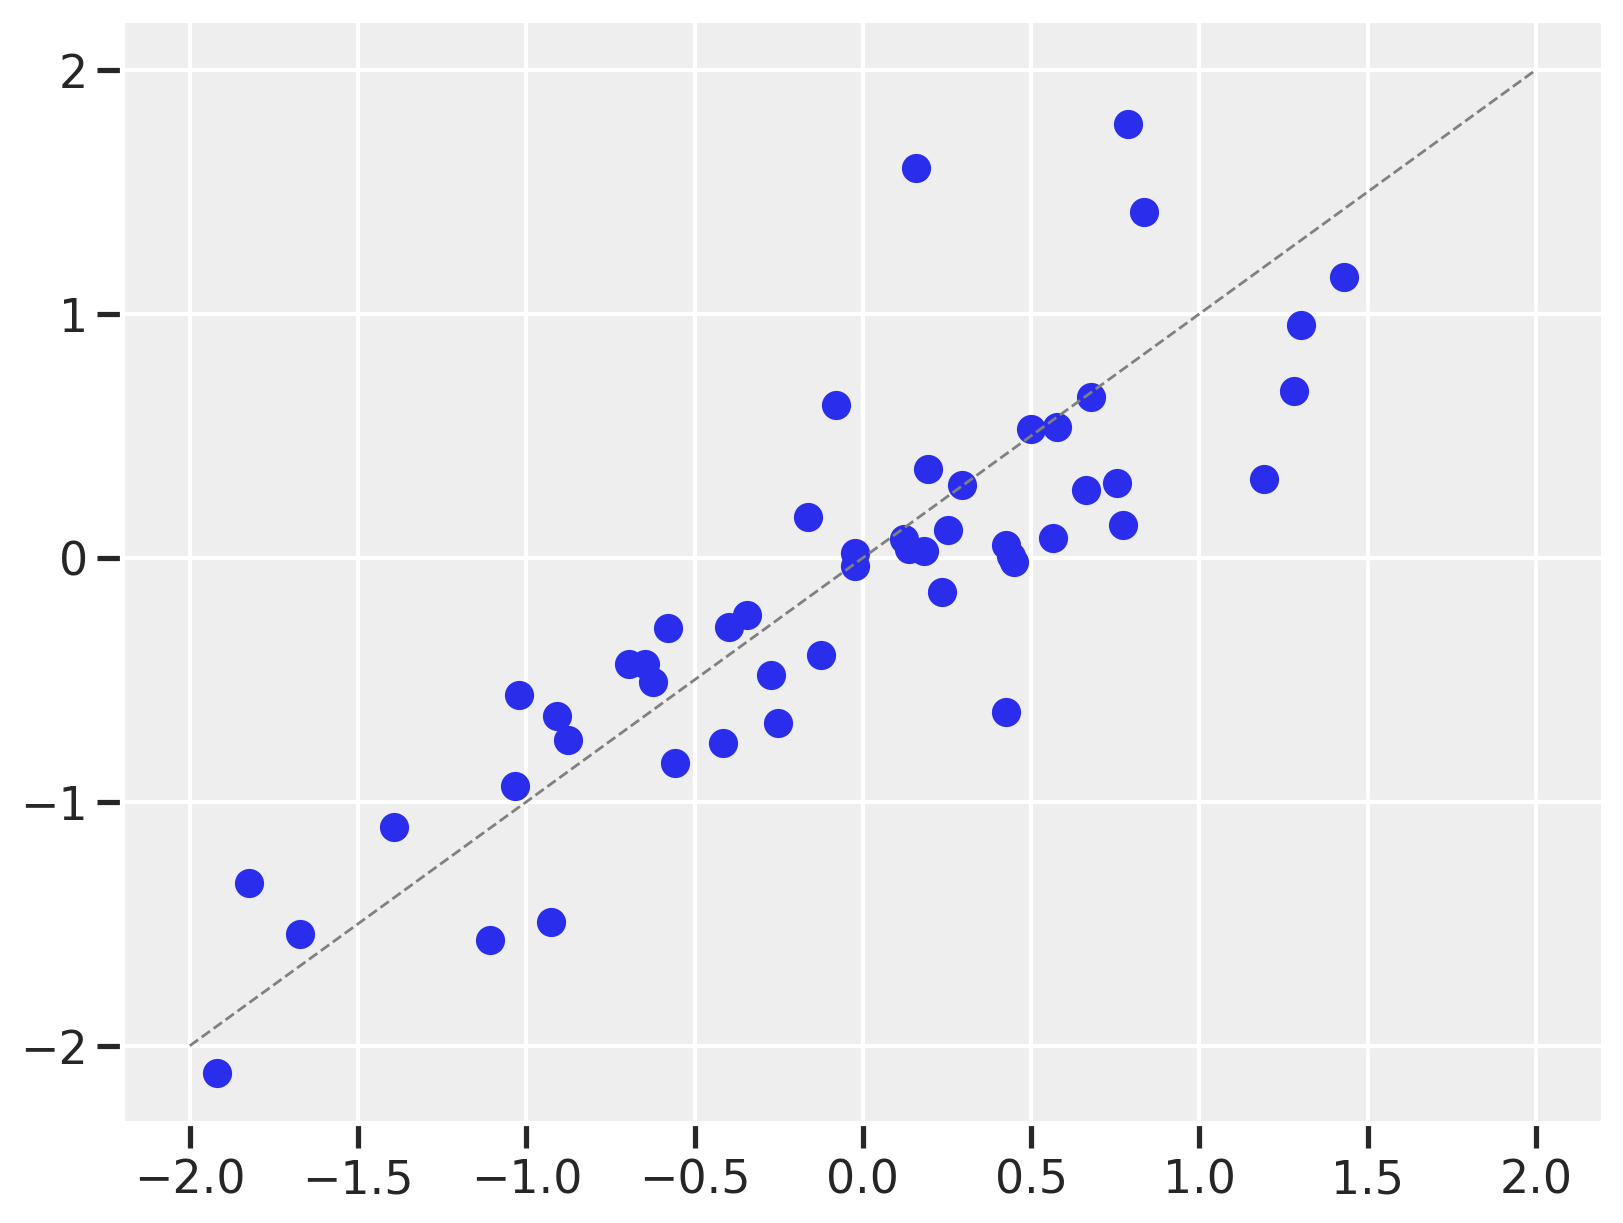

<IPython.core.display.Javascript object>

In [89]:
f, ax1 = plt.subplots(figsize=(8, 6))
df_temp = pd.merge(
    az.summary(trace_m15_1, var_names=["D_true"]),
    az.summary(trace_m15_1b, var_names=["D_true"]),
    left_index=True,
    right_index=True
)
ax1.scatter(df_temp['mean_x'], df_temp['mean_y'])
ax1.plot([-2, 2], [-2, 2], color="gray", lw=1, linestyle="--")
ax1.


In [83]:
df_temp.head()

Empty DataFrame
Columns: [mean, sd, hdi_5.5%, hdi_94.5%, mcse_mean, mcse_sd, ess_mean, ess_sd, ess_bulk, ess_tail, r_hat]
Index: []

<IPython.core.display.Javascript object>

In [79]:
az.summary(trace_m15_1b, var_names=["D_true"])

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
D_true[0]   0.324  0.218    -0.001      0.649      0.010    0.009     512.0   
D_true[1]   0.659  0.337     0.109      1.198      0.023    0.017     206.0   
D_true[2]   0.052  0.200    -0.239      0.349      0.007    0.008     925.0   
D_true[3]   1.149  0.319     0.651      1.692      0.020    0.014     257.0   
D_true[4]  -0.647  0.181    -0.903     -0.349      0.016    0.011     128.0   
D_true[5]   0.278  0.261    -0.118      0.711      0.017    0.012     228.0   
D_true[6]  -1.105  0.234    -1.455     -0.751      0.013    0.009     341.0   
D_true[7]  -0.233  0.301    -0.729      0.175      0.026    0.019     132.0   
D_true[8]  -2.112  0.464    -2.784     -1.342      0.037    0.026     156.0   
D_true[9]  -0.507  0.174    -0.789     -0.253      0.008    0.007     458.0   
D_true[10]  0.135  0.216    -0.183      0.463      0.011    0.008     360.0   
D_true[11] -0.287  0.399    -0.913      0.291      0.034    0.024     136.0   
D_true[12]  1.596  0.374     1.026      2.239      0.030    0.021     158.0   
D_true[13] -0.746  0.190    -1.075     -0.466      0.009    0.006     467.0   
D_true[14]  0.081  0.201    -0.235      0.376      0.008    0.012     616.0   
D_true[15]  0.297  0.211    -0.009      0.633      0.008    0.006     759.0   
D_true[16]  0.529  0.225     0.202      0.921      0.009    0.006     668.0   
D_true[17]  0.685  0.223     0.343      1.054      0.009    0.007     610.0   
D_true[18]  0.007  0.191    -0.276      0.312      0.006    0.009    1013.0   
D_true[19] -0.634  0.341    -1.129     -0.103      0.033    0.023     108.0   
D_true[20] -0.840  0.220    -1.172     -0.495      0.015    0.010     228.0   
D_true[21] -1.566  0.287    -1.994     -1.064      0.024    0.017     146.0   
D_true[22] -0.482  0.215    -0.814     -0.145      0.014    0.010     238.0   
D_true[23] -0.561  0.253    -0.967     -0.179      0.020    0.014     166.0   
D_true[24] -0.016  0.209    -0.317      0.302      0.006    0.008    1058.0   
D_true[25]  0.019  0.202    -0.278      0.339      0.008    0.011     574.0   
D_true[26] -0.032  0.216    -0.358      0.307      0.009    0.009     598.0   
D_true[27]  0.168  0.213    -0.188      0.468      0.008    0.006     747.0   
D_true[28] -0.679  0.220    -1.044     -0.373      0.011    0.008     407.0   
D_true[29] -1.333  0.232    -1.702     -0.958      0.015    0.011     236.0   
D_true[30]  0.027  0.195    -0.275      0.326      0.006    0.008    1172.0   
D_true[31] -1.540  0.249    -1.922     -1.103      0.020    0.014     160.0   
D_true[32]  0.079  0.180    -0.207      0.360      0.006    0.011     991.0   
D_true[33]  0.625  0.366    -0.005      1.173      0.032    0.023     127.0   
D_true[34] -0.397  0.210    -0.720     -0.086      0.015    0.010     207.0   
D_true[35]  0.954  0.271     0.592      1.446      0.013    0.009     438.0   
D_true[36] -0.139  0.198    -0.419      0.178      0.006    0.008    1047.0   
D_true[37] -0.934  0.206    -1.280     -0.633      0.012    0.008     301.0   
D_true[38] -1.493  0.283    -1.942     -1.038      0.020    0.015     195.0   
D_true[39] -0.435  0.190    -0.744     -0.149      0.006    0.005     946.0   
D_true[40]  0.113  0.205    -0.207      0.418      0.006    0.008    1102.0   
D_true[41]  0.307  0.236    -0.049      0.660      0.012    0.009     384.0   
D_true[42]  0.364  0.190     0.045      0.655      0.010    0.007     331.0   
D_true[43]  1.780  0.438     1.129      2.557      0.037    0.026     143.0   
D_true[44] -0.759  0.224    -1.118     -0.424      0.013    0.009     300.0   
D_true[45] -0.285  0.195    -0.594      0.005      0.011    0.008     320.0   
D_true[46]  0.035  0.202    -0.286      0.349      0.010    0.008     410.0   
D_true[47]  0.537  0.229     0.209      0.917      0.009    0.006     686.0   
D_true[48] -0.434  0.205    -0.787     -0.145      0.011    0.008     366.0   
D_true[49]  1.419  0.483     0.637      2.183      0.042    0.0

<IPython.core.display.Javascript object>

Text(0.5, 1.0, '2 x SE model')

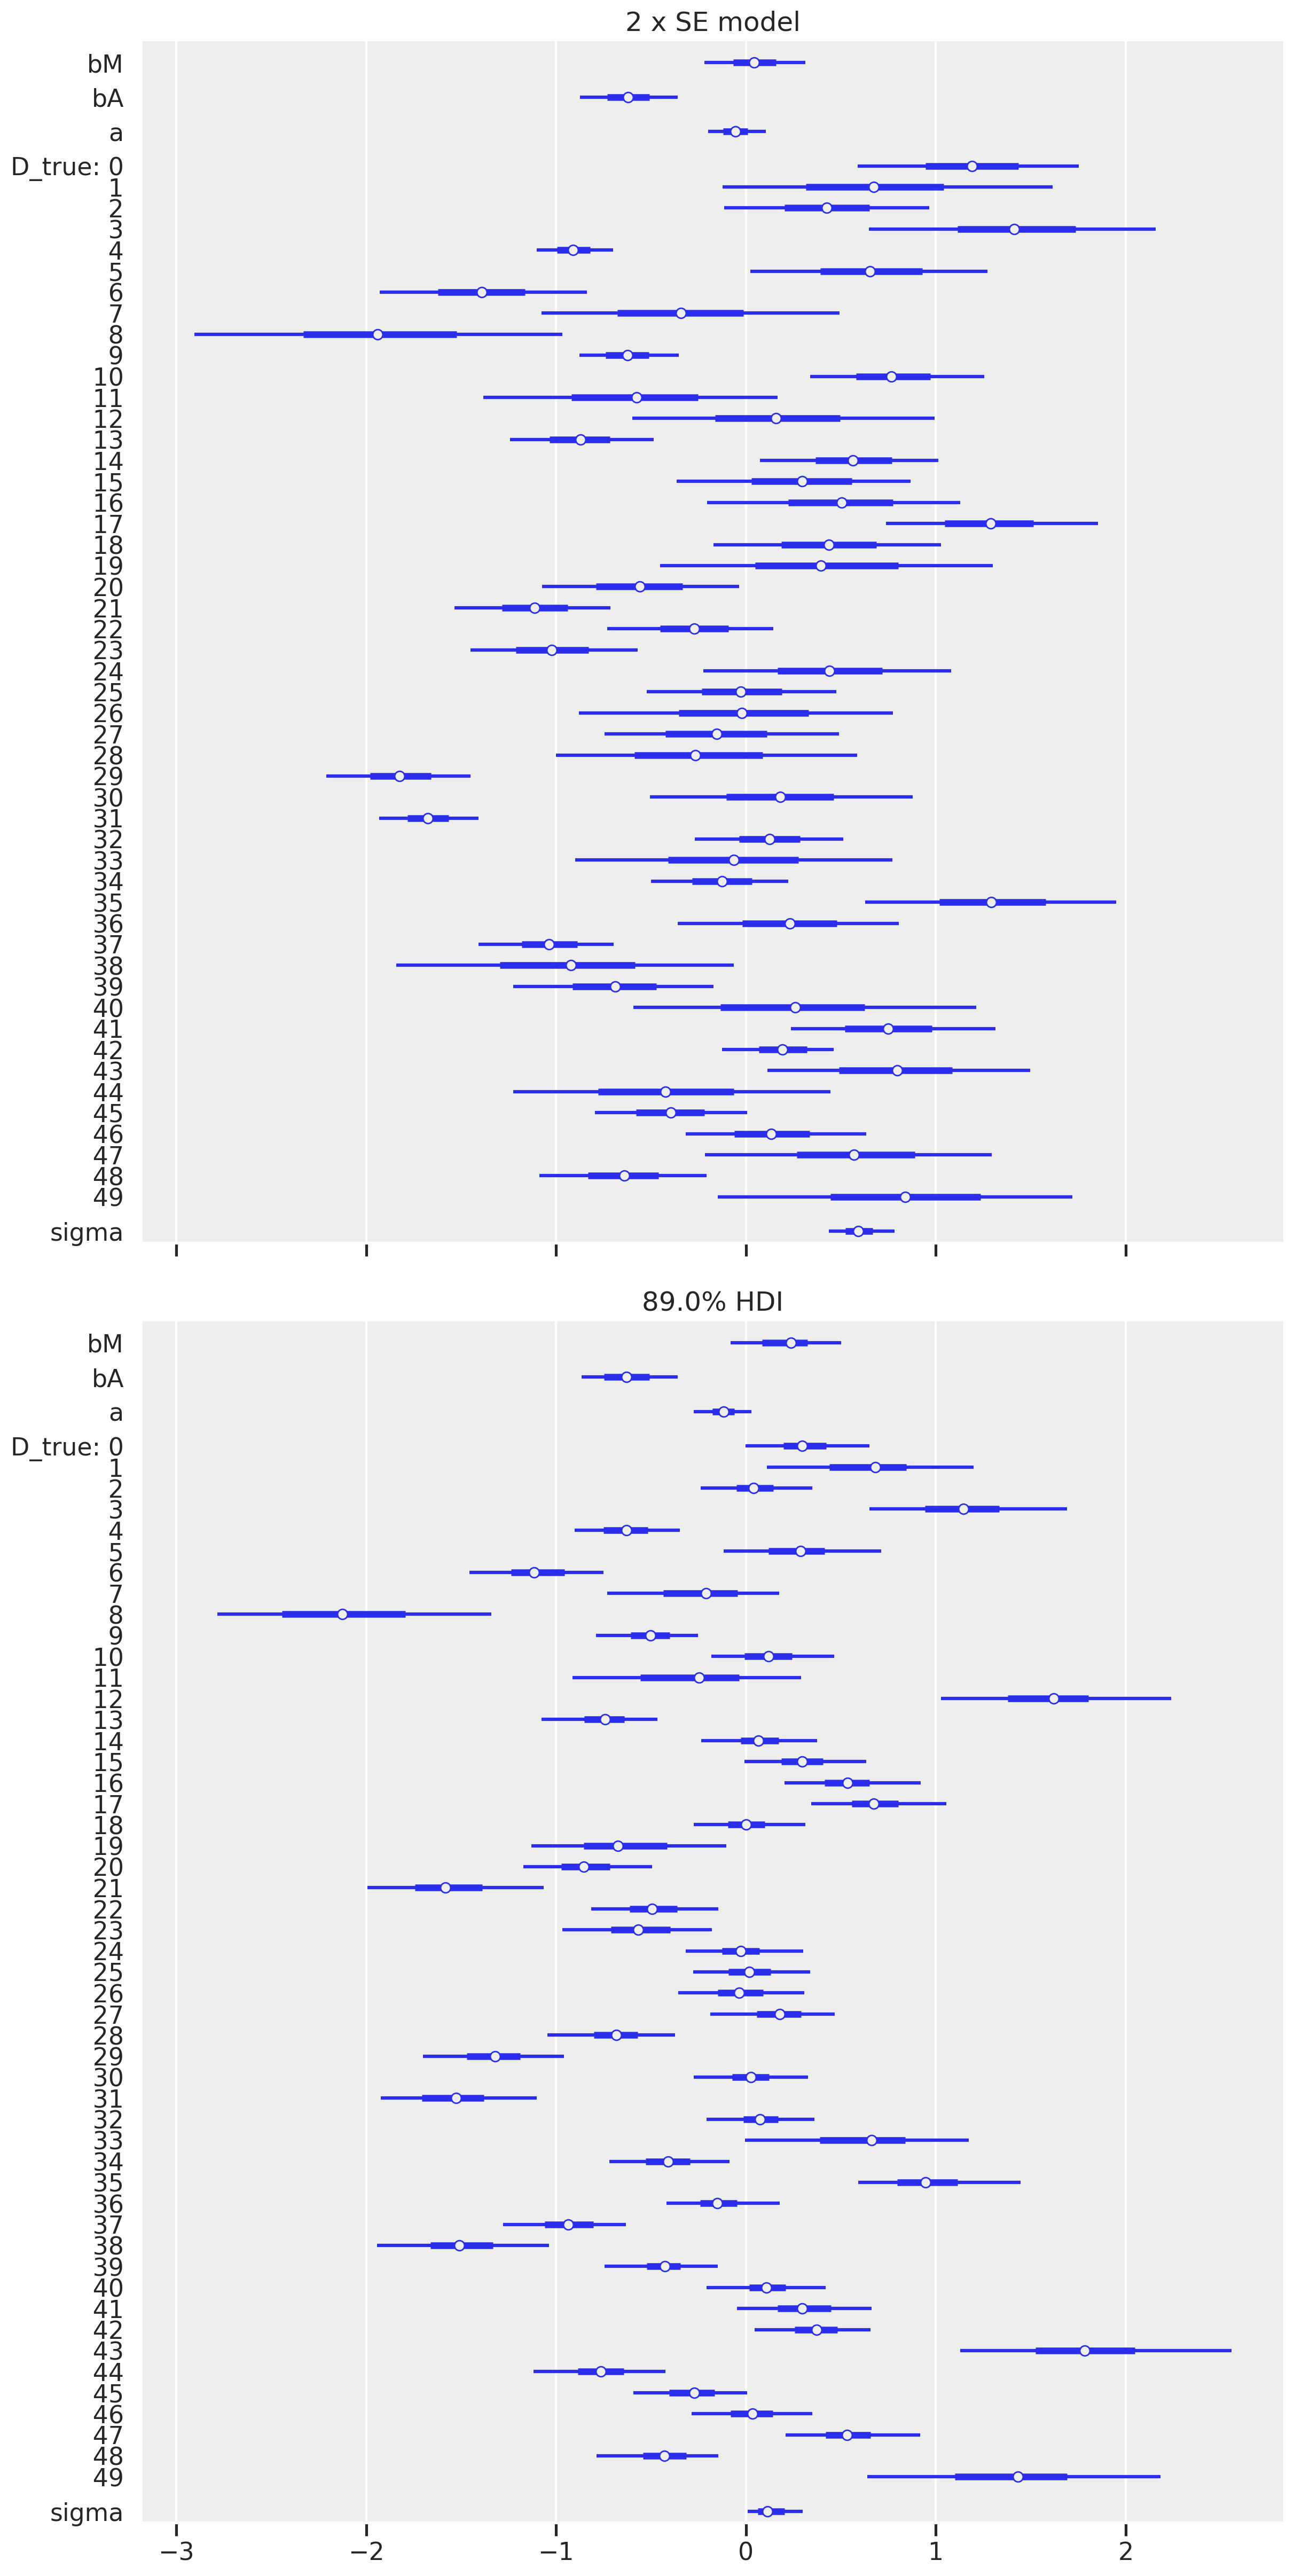

<IPython.core.display.Javascript object>

In [90]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 24), sharex=True)
az.plot_forest(trace_m15_1, combined=True, ax=ax1)
ax1.set_title("original SE model")

az.plot_forest(trace_m15_1b, combined=True, ax=ax2)
ax1.set_title("2 x SE model")

# 15M4

Simulate the following DAG: X -> Y -> Z. 

Now build a model predicting Y using both X and Z. What is the confound that arises?

$$ Y = \beta_1X + \beta_2Z $$

In [10]:
# start with x coming from random draws of a normal distribution around 0
X = stats.norm.rvs(0, 1, size=100)
bX_sim = 0.7

# make y come from random draws of a normal distribution around x
# use a known coefficient
Y = bX_sim * stats.norm.rvs(X, 1, size=100)
bY_sim = 0.3

# make z come from random draws of a normal distribution around x
Z = np.random.normal(Y, 1, size=100)
# Z = np.random.normal(0, 1, size=100)*Y +

df_sim = pd.DataFrame({"X": X, "Y": Y, "Z": Z})

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


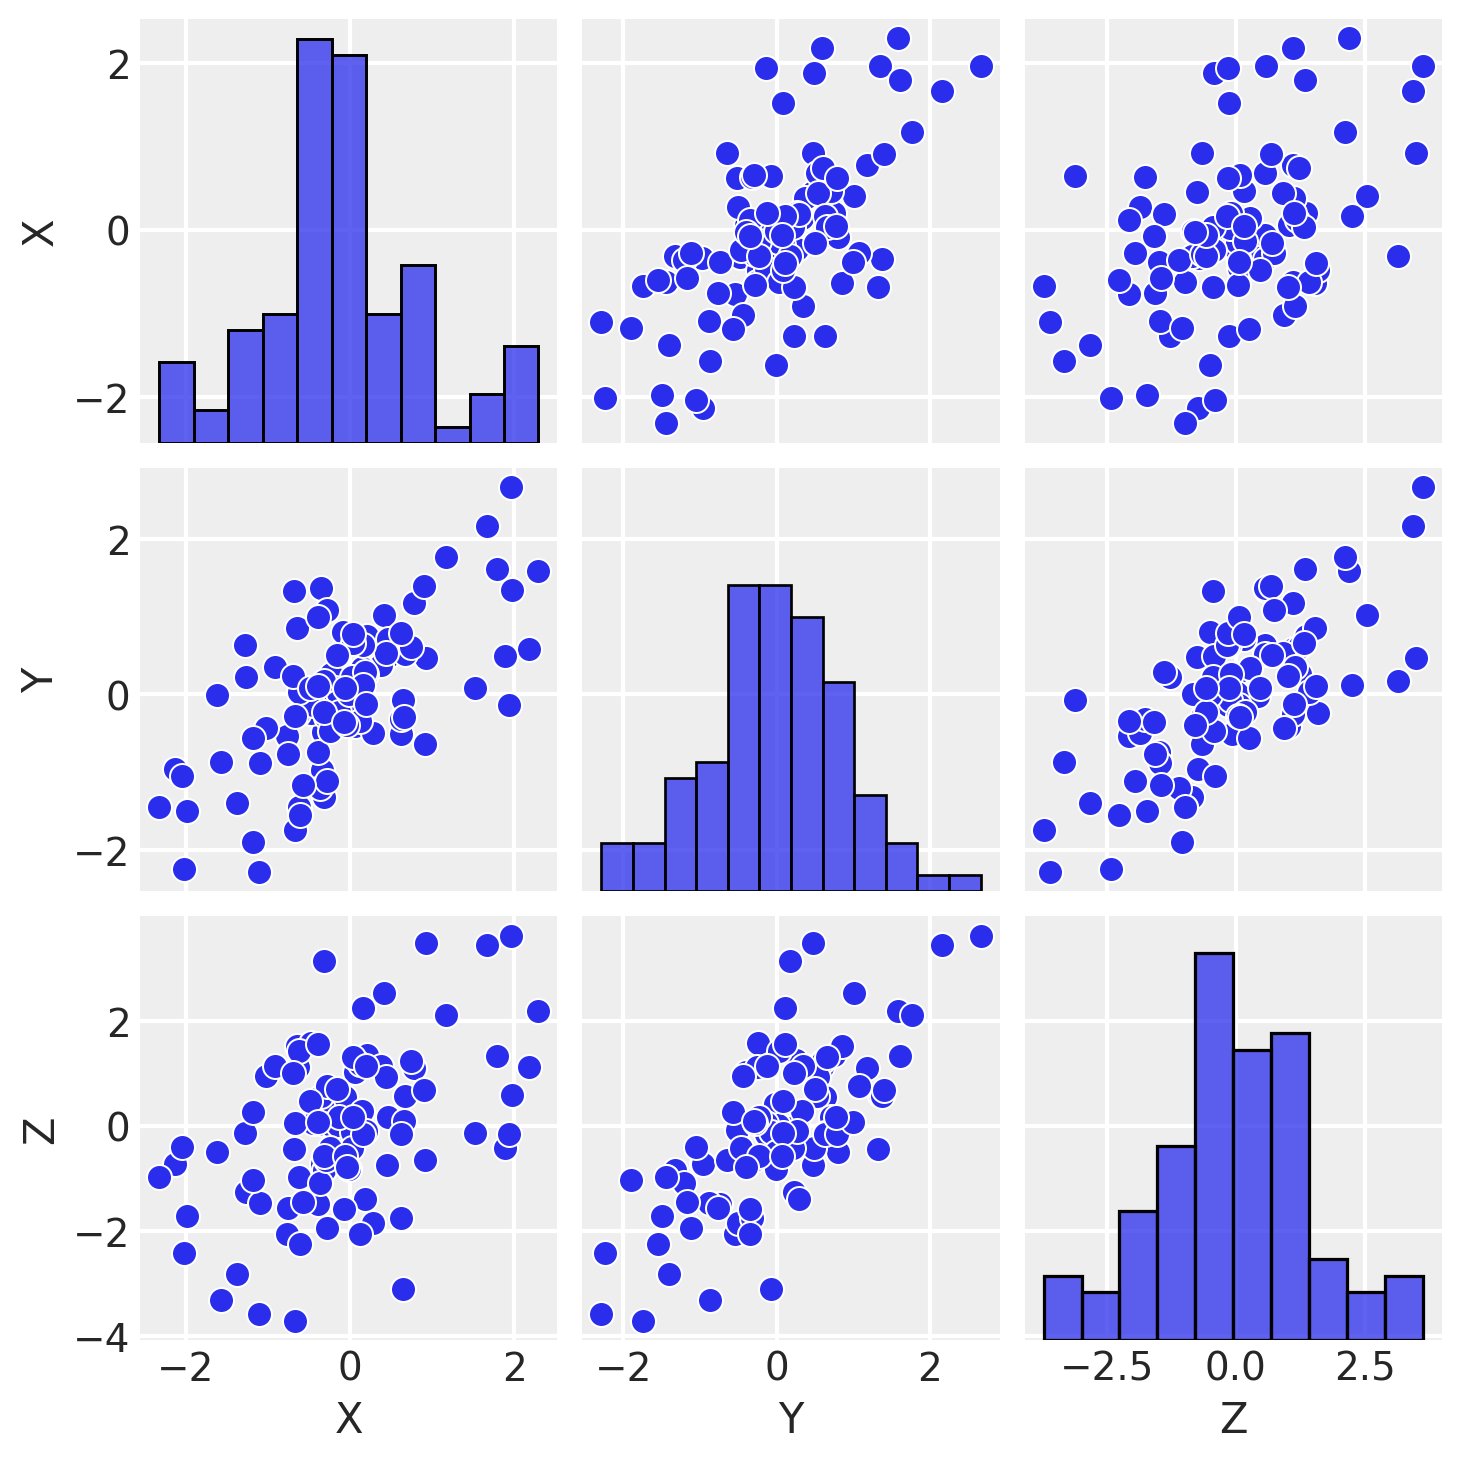

<IPython.core.display.Javascript object>

In [9]:
sns.pairplot(df_sim)

## Using only X as predictor variable

In [17]:
with pm.Model() as m15m4a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = bx * df_sim['X']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4a = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [25]:
sm.OLS(df_sim["Y"], df_sim["X"]).fit().params

X    0.693398
dtype: float64

<IPython.core.display.Javascript object>

In [26]:
az.summary(trace_m15m4a)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
bx     0.692  0.064     0.592      0.796      0.001    0.001    3569.0   
sigma  0.619  0.045     0.541      0.684      0.001    0.001    3512.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
bx     3569.0    3578.0    2653.0    1.0  
sigma  3471.0    3569.0    2740.0    1.0

<IPython.core.display.Javascript object>

## Using X and Z as predictor variables

In [18]:
with pm.Model() as m15m4b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = bx * df_sim['X'] + bz * df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4b = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [27]:
sm.OLS(df_sim["Y"], df_sim[["X", "Z"]]).fit().params

X    0.542048
Z    0.266678
dtype: float64

<IPython.core.display.Javascript object>

In [28]:
az.summary(trace_m15m4b)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
bx     0.542  0.064     0.439      0.642      0.001    0.001    3413.0   
bz     0.266  0.055     0.177      0.352      0.001    0.001    3106.0   
sigma  0.556  0.040     0.490      0.616      0.001    0.000    4507.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
bx     3413.0    3416.0    2685.0    1.0  
bz     3106.0    3103.0    2794.0    1.0  
sigma  4481.0    4485.0    2740.0    1.0

<IPython.core.display.Javascript object>

## Plot comparison

Text(0.5, 1.0, 'X (causal) and Z (descendant)')

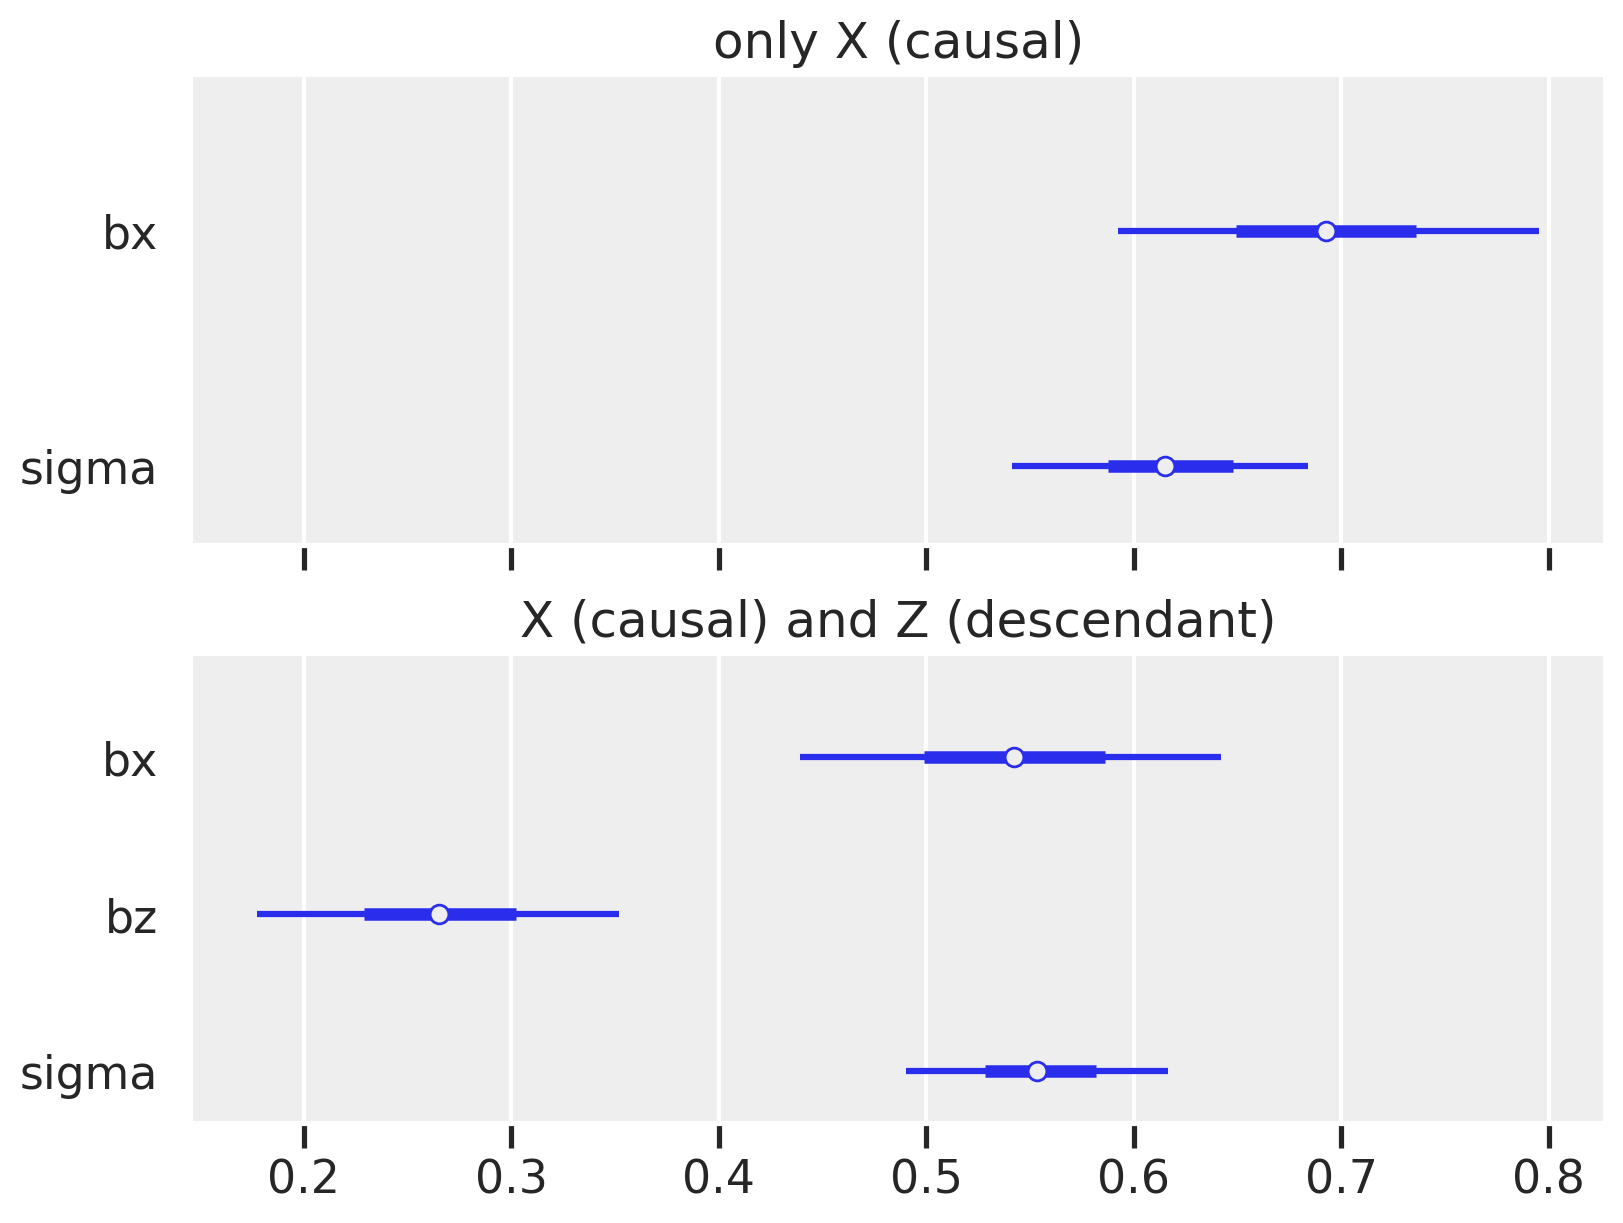

<IPython.core.display.Javascript object>

In [98]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
az.plot_forest(trace_m15m4a, combined=True, ax=ax1)
ax1.set_title("only X (causal)")

az.plot_forest(trace_m15m4b, combined=True, ax=ax2)
ax2.set_title("X (causal) and Z (descendant)")

Marco's tip:
- pretend z is like Y observed
- measurement error ....
- like shrinkage for coefficient



## Random stuff below

### Sample size impact

In [144]:
coef_list = list()
sample_size_list = [10, 100, 200, 500, 1000]
for ss in sample_size_list:
    X1 = stats.norm.rvs(0, 1, size=ss)
    # make y come from random draws of a normal distribution around x
    Y1 = stats.norm.rvs(X1, 1, size=ss)
    coef, se = sm.OLS(Y1, X1).fit().params, sm.OLS(Y1, X1).fit().bse
    coef_list.append((coef[0], se[0]))


<IPython.core.display.Javascript object>

array([0.41306031, 0.10459929, 0.07013674, 0.0455392 , 0.032457  ])

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'sample size'), Text(0, 0.5, 'standard error')]

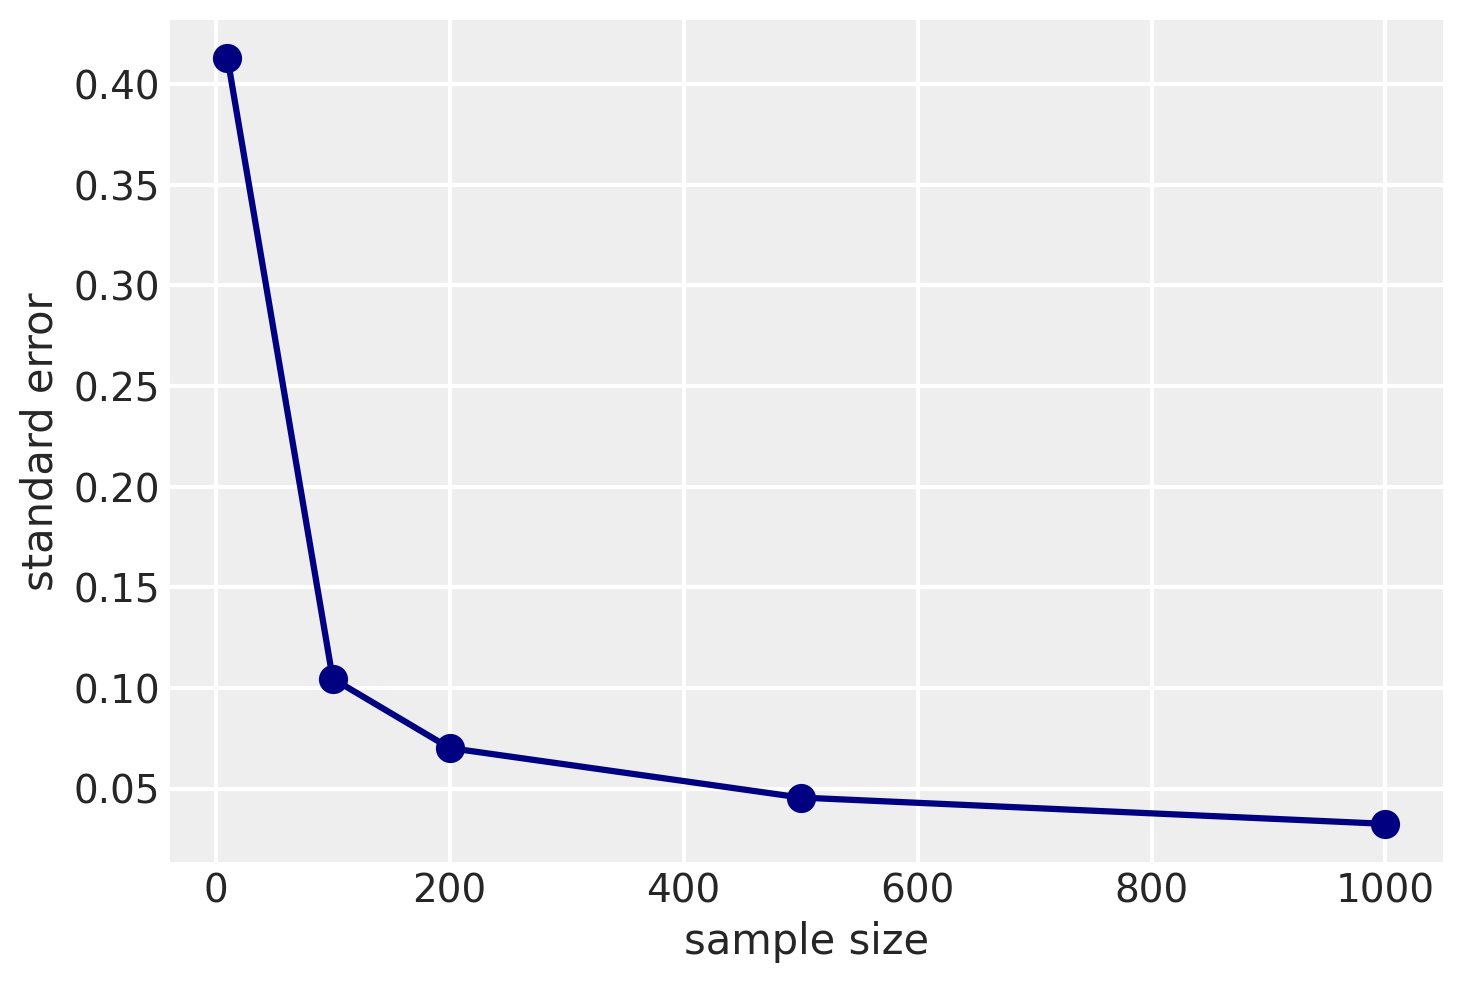

<IPython.core.display.Javascript object>

In [158]:
f, ax1 = plt.subplots()
for i, ss in enumerate(sample_size_list):
    ax1.scatter(ss, coef_list[i][1], label=str(ss), color='navy')
ax1.plot(sample_size_list, np.array(coef_list)[:, 1], color='navy')
ax1.set(xlabel='sample size', ylabel='standard error')

In [145]:
coef_list

[(1.4738356747569061, 0.4130603102642782),
 (1.1425773407005966, 0.10459929433531728),
 (0.9693379977060048, 0.07013674418669784),
 (0.9581939304346598, 0.045539195254065586),
 (0.9801280818471241, 0.03245700083272577)]

<IPython.core.display.Javascript object>

In [36]:
# start with x coming from random draws of a normal distribution around 0
X1 = stats.norm.rvs(0, 1, size=100)
# make y come from random draws of a normal distribution around x
Y1 = stats.norm.rvs(X1, 1, size=100)
# make z come from random draws of a normal distribution around x
Z1 = np.random.normal(Y1, 1, size=100)
# Z = np.random.normal(0, 1, size=100)*Y + 

df_sim = pd.DataFrame(
    {"X":X1, "Y":Y1, "Z":Z1}
)

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


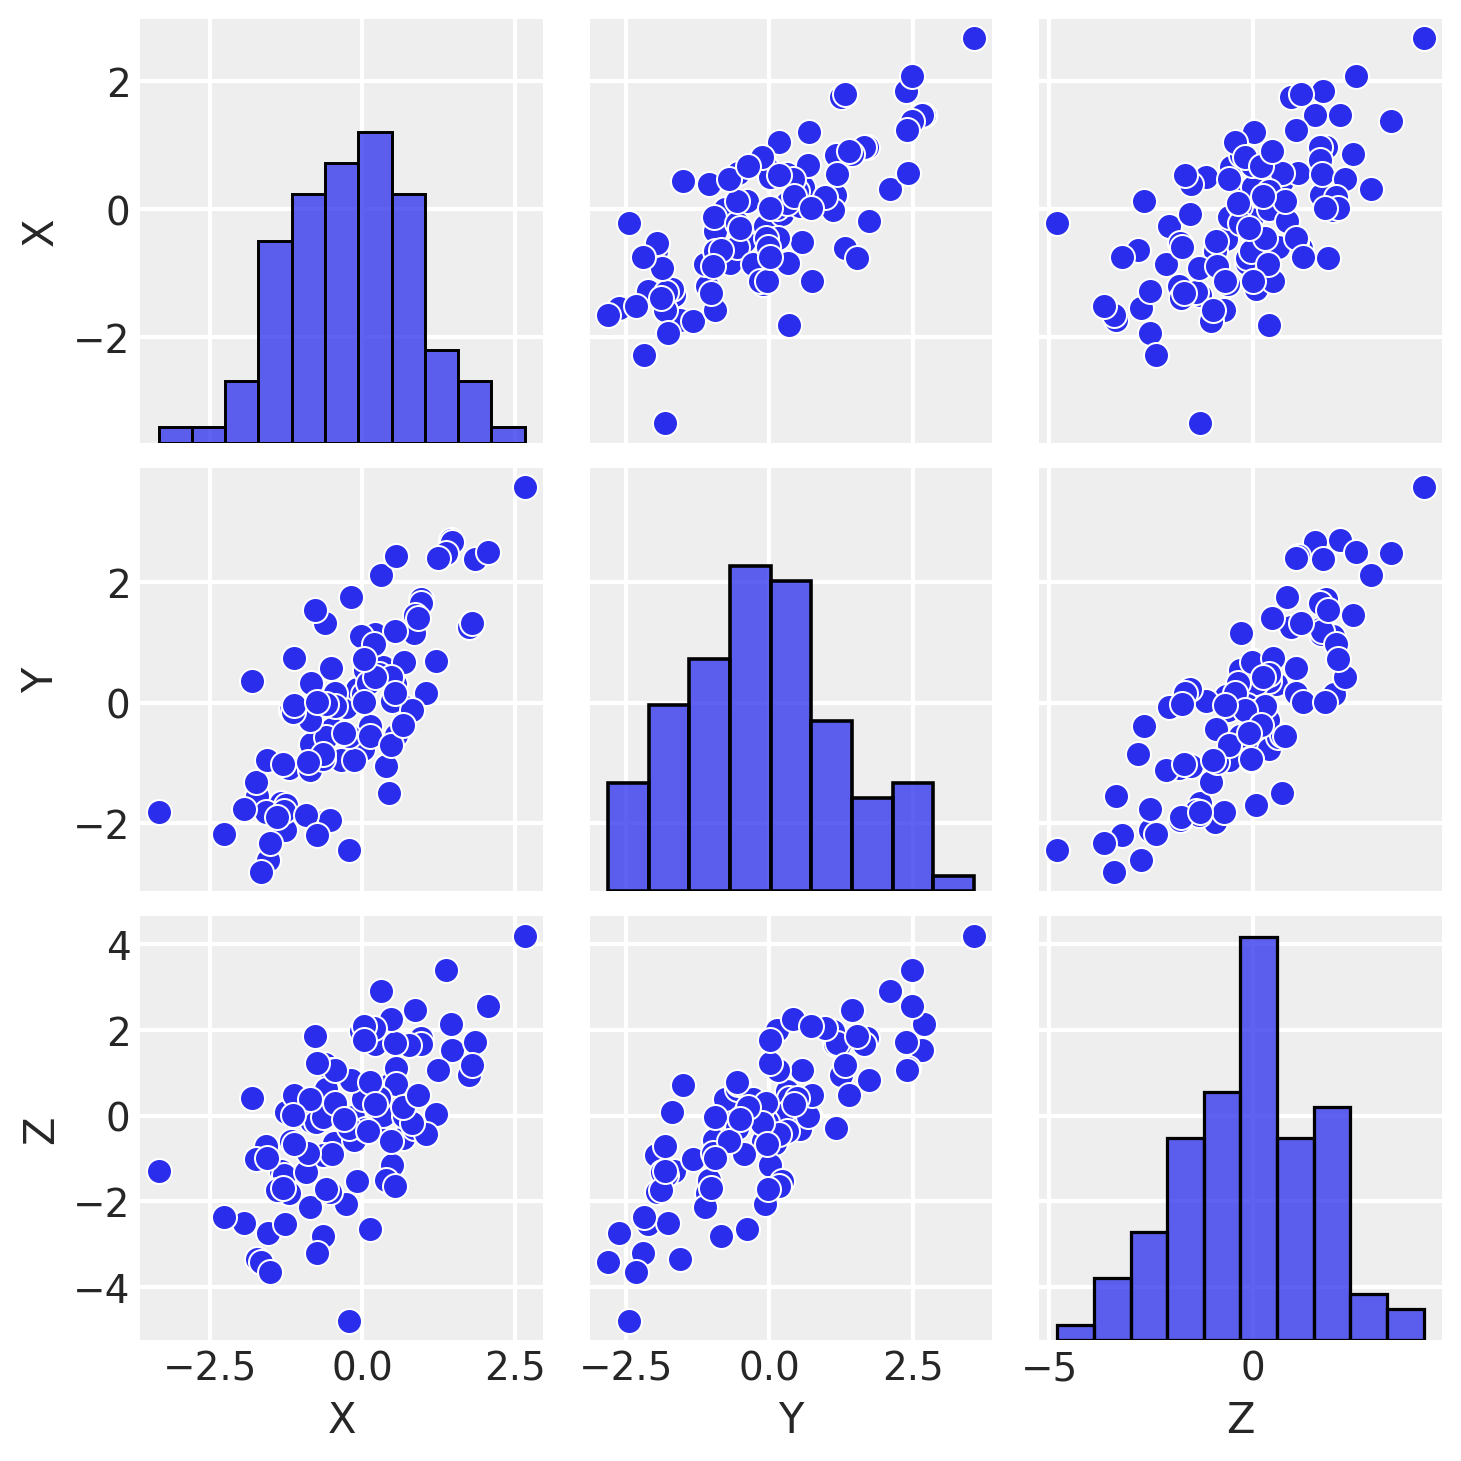

<IPython.core.display.Javascript object>

In [49]:
sns.pairplot(df_sim)

### Using `statsmodels`

In [45]:
import statsmodels.api as sm

<IPython.core.display.Javascript object>

In [47]:
res = sm.OLS(df_sim['Y'], df_sim['X']).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.551
Model:                            OLS   Adj. R-squared (uncentered):              0.546
Method:                 Least Squares   F-statistic:                              121.3
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                    6.85e-19
Time:                        16:25:34   Log-Likelihood:                         -133.42
No. Observations:                 100   AIC:                                      268.8
Df Residuals:                      99   BIC:                                      271.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.9658      0.088     11.013      0.000       0.792       1.140
==============================================================================
Omnibus:                        0.067   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.207
Skew:                           0.044   Prob(JB):                        0.902
Kurtosis:                       2.796   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [48]:
res = sm.OLS(df_sim['Y'], df_sim[['X', 'Z']]).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.755
Model:                            OLS   Adj. R-squared (uncentered):              0.750
Method:                 Least Squares   F-statistic:                              150.9
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                    1.20e-30
Time:                        16:26:00   Log-Likelihood:                         -103.11
No. Observations:                 100   AIC:                                      210.2
Df Residuals:                      98   BIC:                                      215.4
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.5155      0.082      6.289      0.000       0.353       0.678
Z              0.4702      0.052      9.038      0.000       0.367       0.573
==============================================================================
Omnibus:                        0.927   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                0.814
Skew:                          -0.219   Prob(JB):                        0.666
Kurtosis:                       2.943   Cond. No.                         2.36
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

## Using `pymc`

In [50]:
df_sim.head()

X         Y         Z
0  0.198388  0.521408 -0.246524
1  1.459678  2.691161  2.144239
2  0.542236  0.309511  0.578994
3 -0.472632  0.101527 -0.640011
4 -1.727338 -1.557110 -3.349159

<IPython.core.display.Javascript object>

In [53]:
with pm.Model() as m15m4a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X']

    # likelihood
    y = pm.Normal("h1", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4a = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

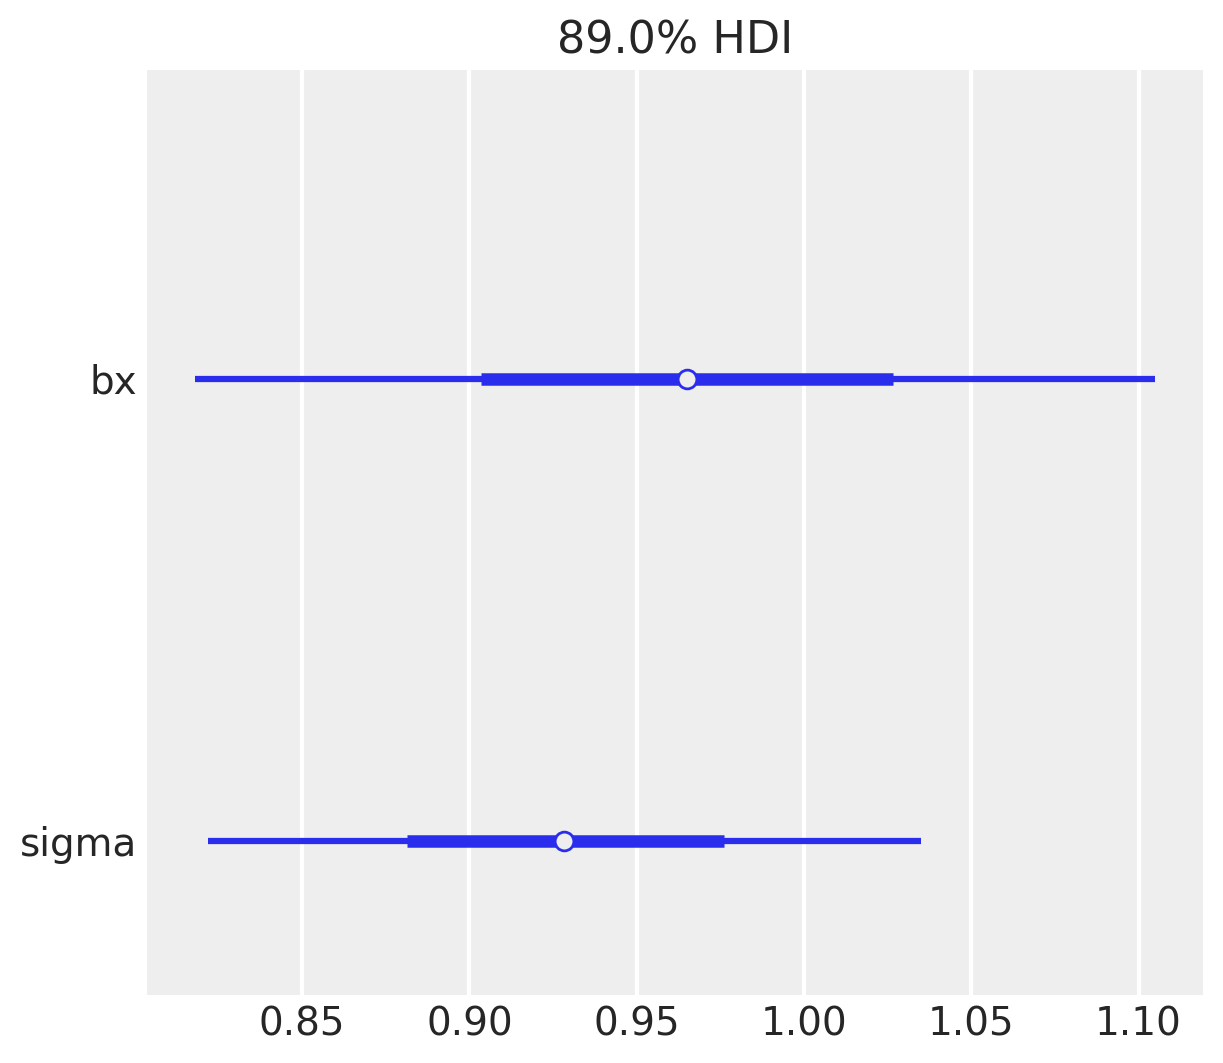

<IPython.core.display.Javascript object>

In [54]:
az.plot_forest(trace_m15m4a, combined=True)

In [56]:
with pm.Model() as m15m4b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X'] + bz*df_sim['Z']

    # likelihood
    y = pm.Normal("h1", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4b = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

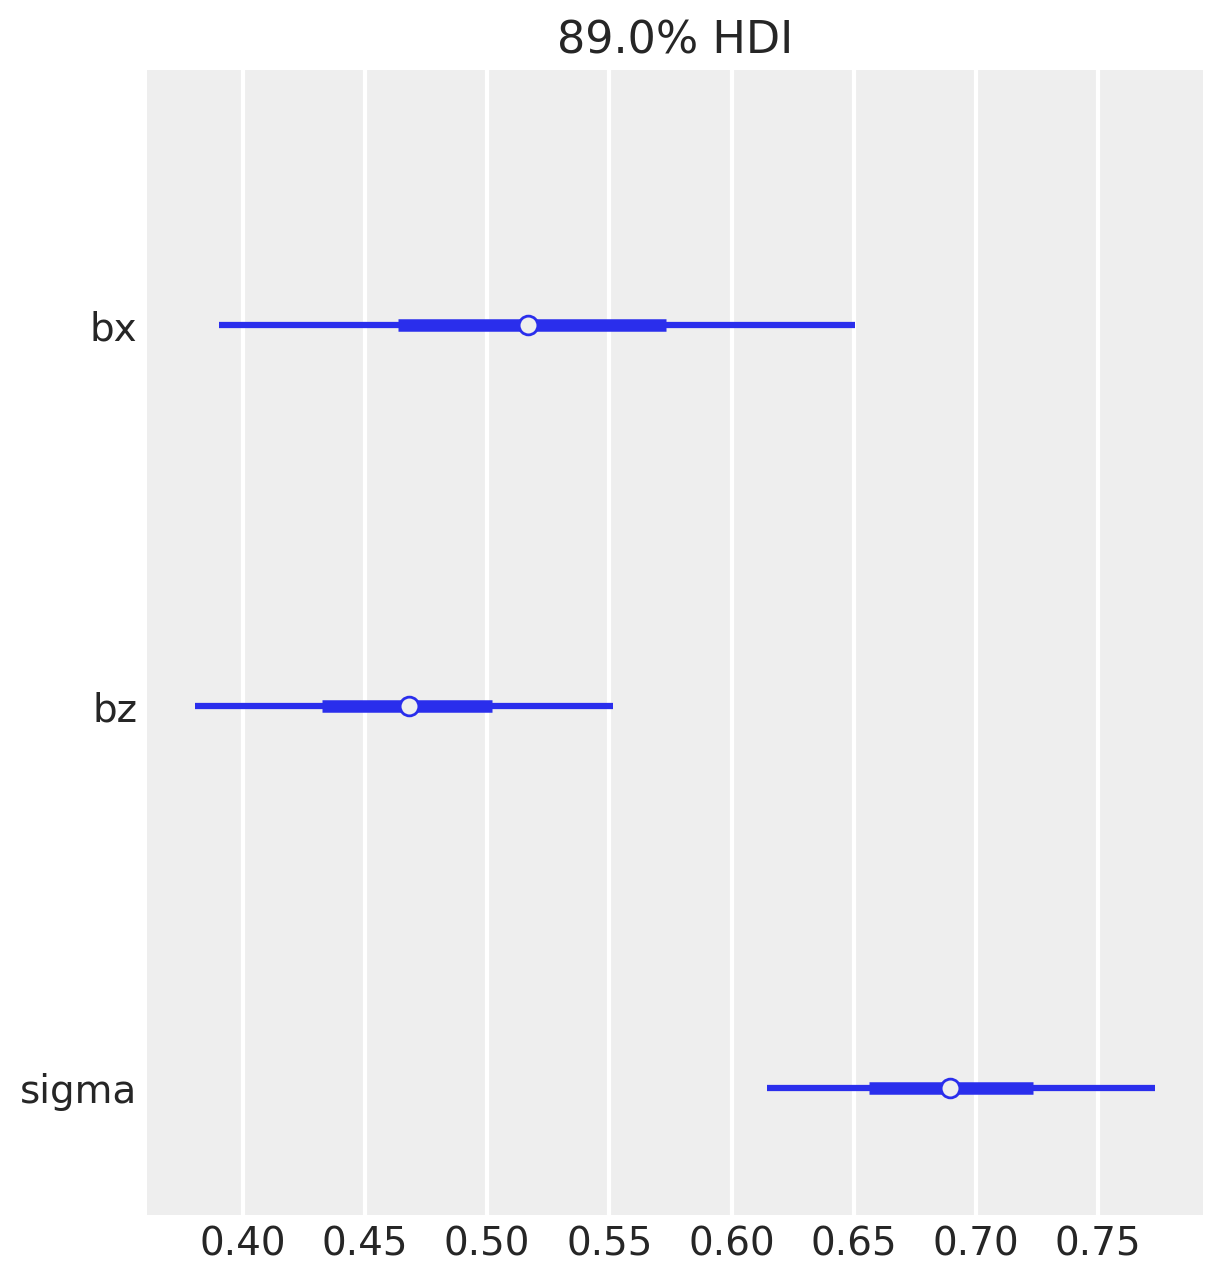

<IPython.core.display.Javascript object>

In [57]:
az.plot_forest(trace_m15m4b, combined=True)

In [ ]:
stats.linregress(X1, Y1)

## Change coefficient of sim

In [108]:
N_samples = 1000

# start with x coming from random draws of a normal distribution around 0
X1 = stats.norm.rvs(0, 1, size=N_samples)
bX_sim = 0.7

# make y come from random draws of a normal distribution around x
#Y1 = bX_sim * stats.norm.rvs(X1, 1, size=N_samples)
Y1 = stats.norm.rvs(bX_sim * X1, 1, size=N_samples)
# Y1 = bX_sim*X1
bY_sim = 0.3

# make z come from random draws of a normal distribution around x
Z1 = bY_sim * np.random.normal(Y1, 1, size=N_samples)
# Z = np.random.normal(0, 1, size=100)*Y + 

df_sim = pd.DataFrame(
    {"X":X1, "Y":Y1, "Z":Z1}
)

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Density'>

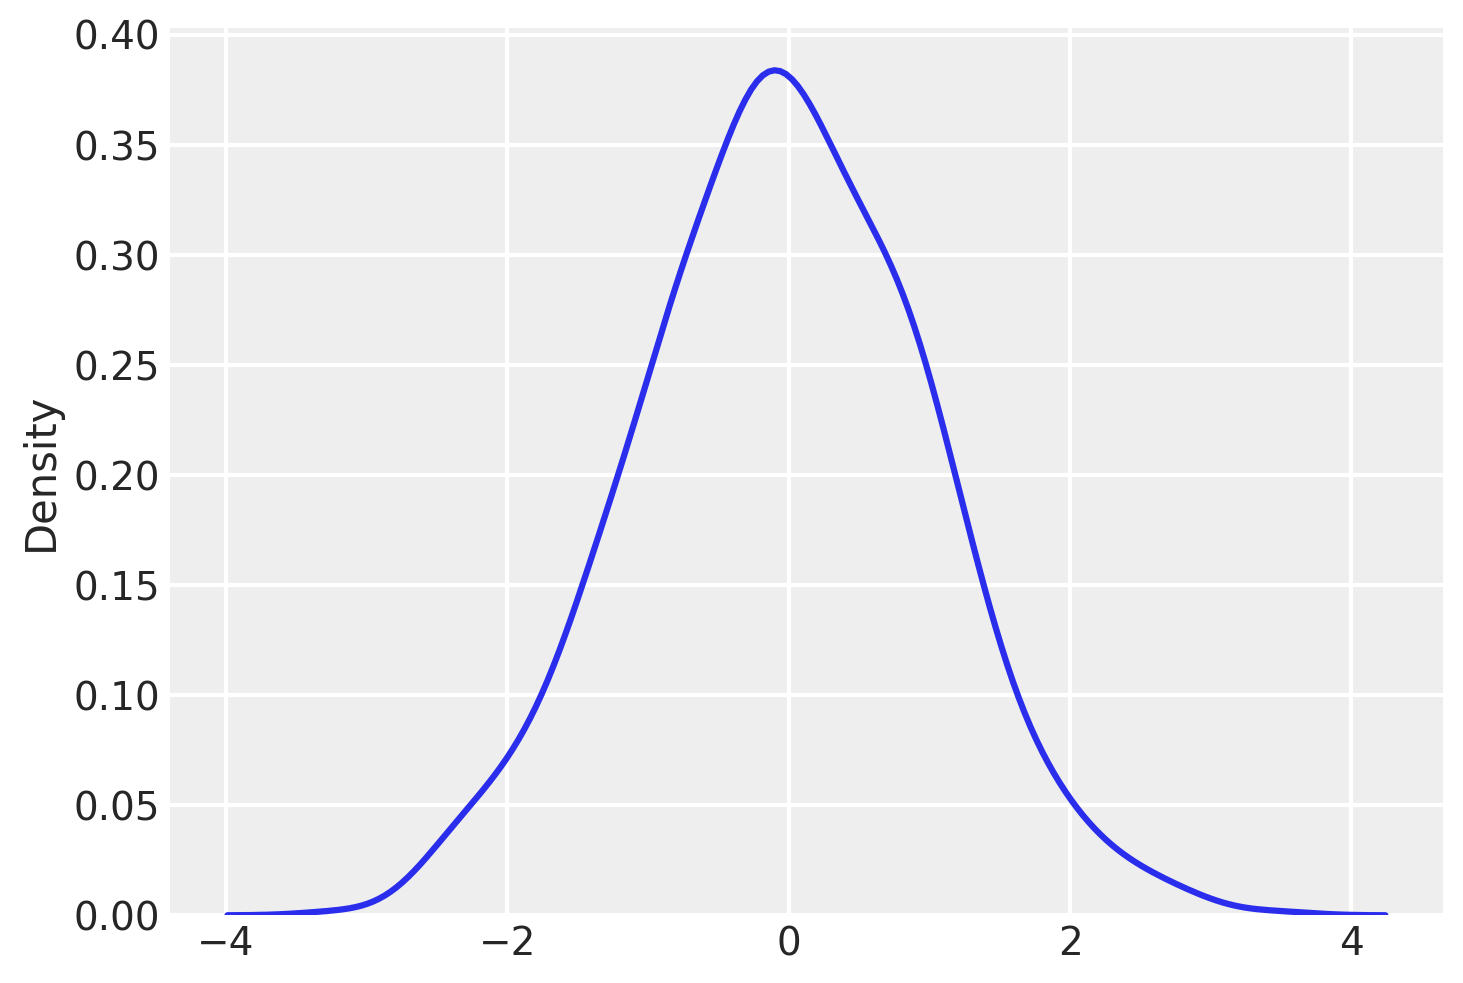

<IPython.core.display.Javascript object>

In [109]:
sns.kdeplot(X1)

In [103]:
(bX_sim * X1).mean()

0.097787496274374

<IPython.core.display.Javascript object>

In [101]:
X1.mean(), Y1.mean()

(0.13969642324910575, 0.15530444695953843)

<IPython.core.display.Javascript object>

In [100]:
0.7*0.3

0.21

<IPython.core.display.Javascript object>

In [110]:
sm.OLS(df_sim['Y'], df_sim[['X']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.354
Model:                            OLS   Adj. R-squared (uncentered):              0.354
Method:                 Least Squares   F-statistic:                              548.4
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                    5.08e-97
Time:                        18:07:42   Log-Likelihood:                         -1415.7
No. Observations:                1000   AIC:                                      2833.
Df Residuals:                     999   BIC:                                      2838.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.7177      0.031     23.417      0.000       0.658       0.778
==============================================================================
Omnibus:                        6.535   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                8.102
Skew:                           0.070   Prob(JB):                       0.0174
Kurtosis:                       3.418   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [111]:
sm.OLS(df_sim['Y'], df_sim[['X', 'Z']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.672
Model:                            OLS   Adj. R-squared (uncentered):              0.671
Method:                 Least Squares   F-statistic:                              1023.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                   2.32e-242
Time:                        18:08:07   Log-Likelihood:                         -1076.9
No. Observations:                1000   AIC:                                      2158.
Df Residuals:                     998   BIC:                                      2168.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.3742      0.024     15.281      0.000       0.326       0.422
Z              1.6637      0.054     31.095      0.000       1.559       1.769
==============================================================================
Omnibus:                        2.397   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                2.265
Skew:                           0.090   Prob(JB):                        0.322
Kurtosis:                       3.148   Cond. No.                         2.57
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


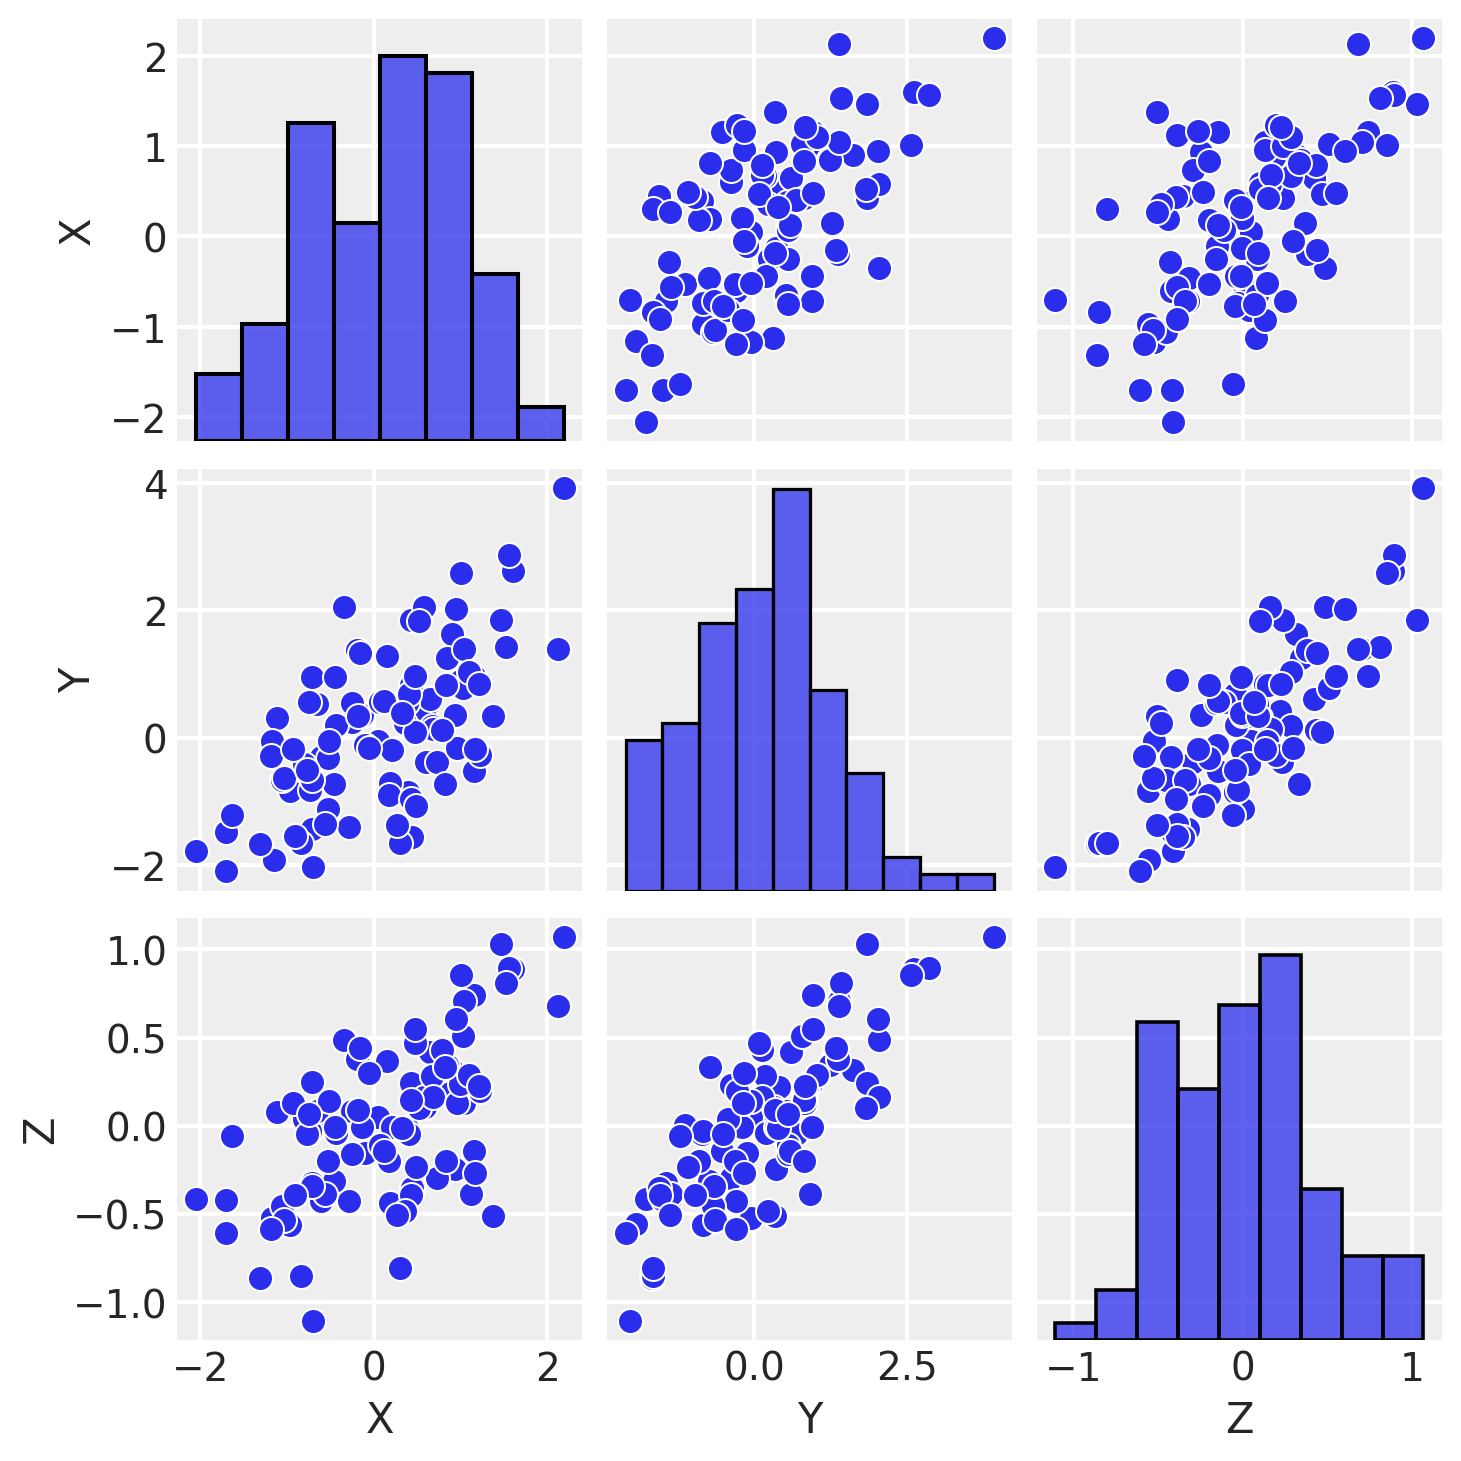

<IPython.core.display.Javascript object>

In [97]:
sns.pairplot(df_sim)

In [112]:
sm.OLS(df_sim['Y'], df_sim[['Z']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.595
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              1470.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                   1.76e-198
Time:                        18:08:37   Log-Likelihood:                         -1182.1
No. Observations:                1000   AIC:                                      2366.
Df Residuals:                     999   BIC:                                      2371.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z              2.0326      0.053     38.339      0.000       1.929       2.137
==============================================================================
Omnibus:                        3.821   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                3.678
Skew:                           0.132   Prob(JB):                        0.159
Kurtosis:                       3.136   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

## Change the outcome

In [113]:
sm.OLS(df_sim['Z'], df_sim[['X', 'Y']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Z   R-squared (uncentered):                   0.595
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              734.5
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                   7.45e-197
Time:                        18:09:26   Log-Likelihood:                         -213.32
No. Observations:                1000   AIC:                                      430.6
Df Residuals:                     998   BIC:                                      440.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             -0.0058      0.011     -0.506      0.613      -0.028       0.017
Y              0.2958      0.010     31.095      0.000       0.277       0.314
==============================================================================
Omnibus:                        2.486   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.288   Jarque-Bera (JB):                2.438
Skew:                          -0.121   Prob(JB):                        0.296
Kurtosis:                       3.011   Cond. No.                         2.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [117]:
sm.OLS(df_sim['Z'], df_sim[['Y']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Z   R-squared (uncentered):                   0.595
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              1470.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                   1.76e-198
Time:                        18:10:13   Log-Likelihood:                         -213.45
No. Observations:                1000   AIC:                                      428.9
Df Residuals:                     999   BIC:                                      433.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Y              0.2929      0.008     38.339      0.000       0.278       0.308
==============================================================================
Omnibus:                        2.608   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.559
Skew:                          -0.124   Prob(JB):                        0.278
Kurtosis:                       3.012   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [118]:
sm.OLS(df_sim['Z'], df_sim[['X']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Z   R-squared (uncentered):                   0.204
Model:                            OLS   Adj. R-squared (uncentered):              0.203
Method:                 Least Squares   F-statistic:                              255.3
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                    2.38e-51
Time:                        18:10:30   Log-Likelihood:                         -552.03
No. Observations:                1000   AIC:                                      1106.
Df Residuals:                     999   BIC:                                      1111.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.2065      0.013     15.978      0.000       0.181       0.232
==============================================================================
Omnibus:                        1.707   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.426   Jarque-Bera (JB):                1.607
Skew:                          -0.095   Prob(JB):                        0.448
Kurtosis:                       3.051   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [119]:
sm.OLS(df_sim['Z'], df_sim[['X']]).fit().params

X    0.206468
dtype: float64

<IPython.core.display.Javascript object>

In [120]:
sm.OLS(df_sim['Z'], df_sim[['X', 'Y']]).fit().params

X   -0.005799
Y    0.295766
dtype: float64

<IPython.core.display.Javascript object>

## Colliders pointing to Z

In [121]:
N_samples = 1000

# start with x coming from random draws of a normal distribution around 0
X1 = stats.norm.rvs(0, 1, size=N_samples)
bX_sim = 0.7

# make y come from random draws of a normal distribution around x
#Y1 = bX_sim * stats.norm.rvs(X1, 1, size=N_samples)
Y1 = stats.norm.rvs(1, 1, size=N_samples)
# Y1 = bX_sim*X1
bY_sim = 0.3

# make z come from random draws of a normal distribution around x
Z1 = bX_sim * np.random.normal(X1, 1, size=N_samples) + bY_sim * np.random.normal(Y1, 1, size=N_samples) 
# Z = np.random.normal(0, 1, size=100)*Y + 

df_sim = pd.DataFrame(
    {"X":X1, "Y":Y1, "Z":Z1}
)

<IPython.core.display.Javascript object>

In [122]:
sm.OLS(df_sim['Z'], df_sim[['X', 'Y']]).fit().params

X    0.674042
Y    0.298147
dtype: float64

<IPython.core.display.Javascript object>

In [123]:
sm.OLS(df_sim['Z'], df_sim[['X']]).fit().params

X    0.667398
dtype: float64

<IPython.core.display.Javascript object>

In [124]:
sm.OLS(df_sim['Z'], df_sim[['Y']]).fit().params

Y    0.290141
dtype: float64

<IPython.core.display.Javascript object>

In [125]:
sm.OLS(df_sim['X'], df_sim[['Y']]).fit().params

Y   -0.011876
dtype: float64

<IPython.core.display.Javascript object>

In [126]:
sm.OLS(df_sim['X'], df_sim[['Y', 'Z']]).fit().params

Y   -0.210500
Z    0.684574
dtype: float64

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


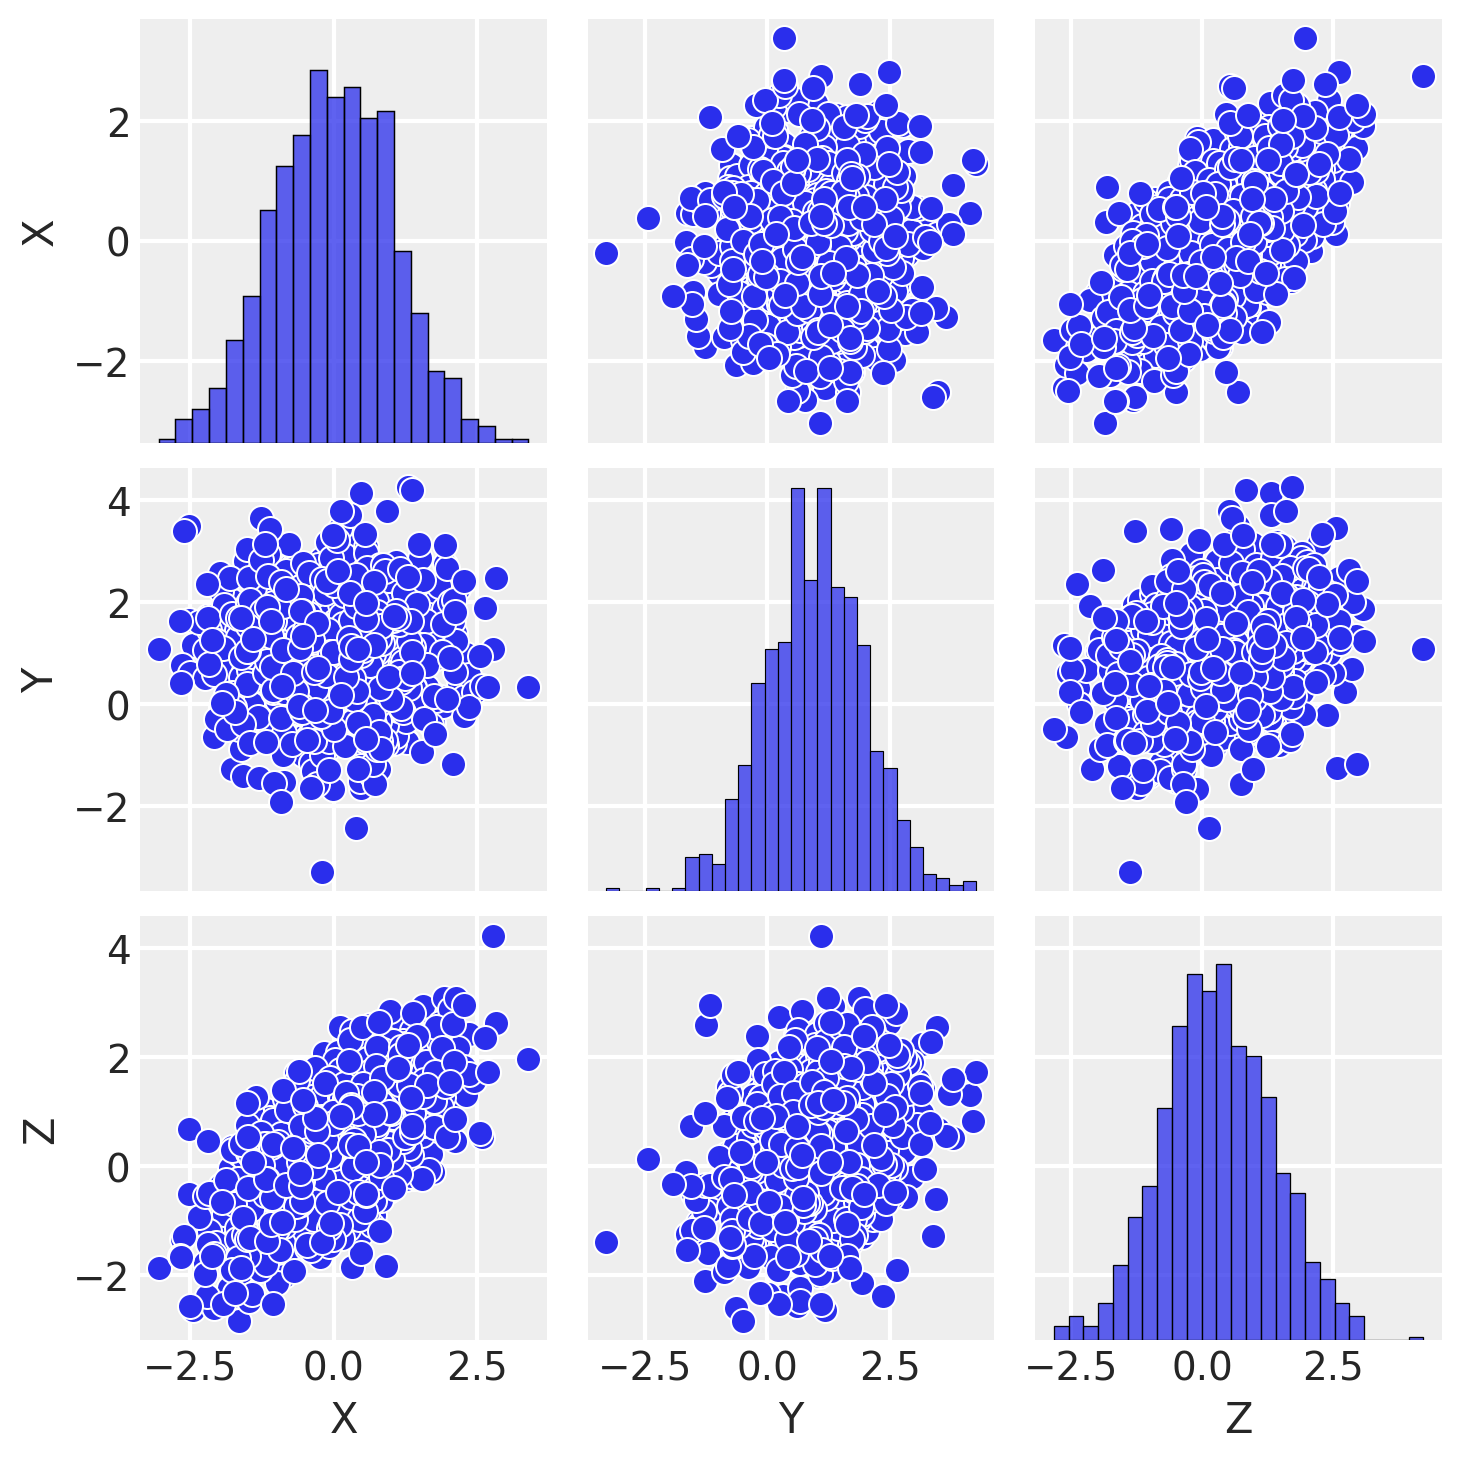

<IPython.core.display.Javascript object>

In [127]:
sns.pairplot(df_sim)

In [85]:
with pm.Model() as m15m4a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4a = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In [87]:
with pm.Model() as m15m4b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X'] + bz*df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4b = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In [89]:
with pm.Model() as m15m4c:
    
    # priors
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bz*df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4c = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4c = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

In [92]:
az.summary(trace_m15m4a)
# az.plot_forest(trace_m15m4b, combined=True, ax=ax2)
# az.plot_forest(trace_m15m4c, combined=True, ax=ax3)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
bx     0.620  0.073     0.507      0.736      0.001    0.001    3439.0   
sigma  0.721  0.052     0.641      0.802      0.001    0.001    3362.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
bx     3439.0    3449.0    2680.0    1.0  
sigma  3287.0    3491.0    2438.0    1.0

<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

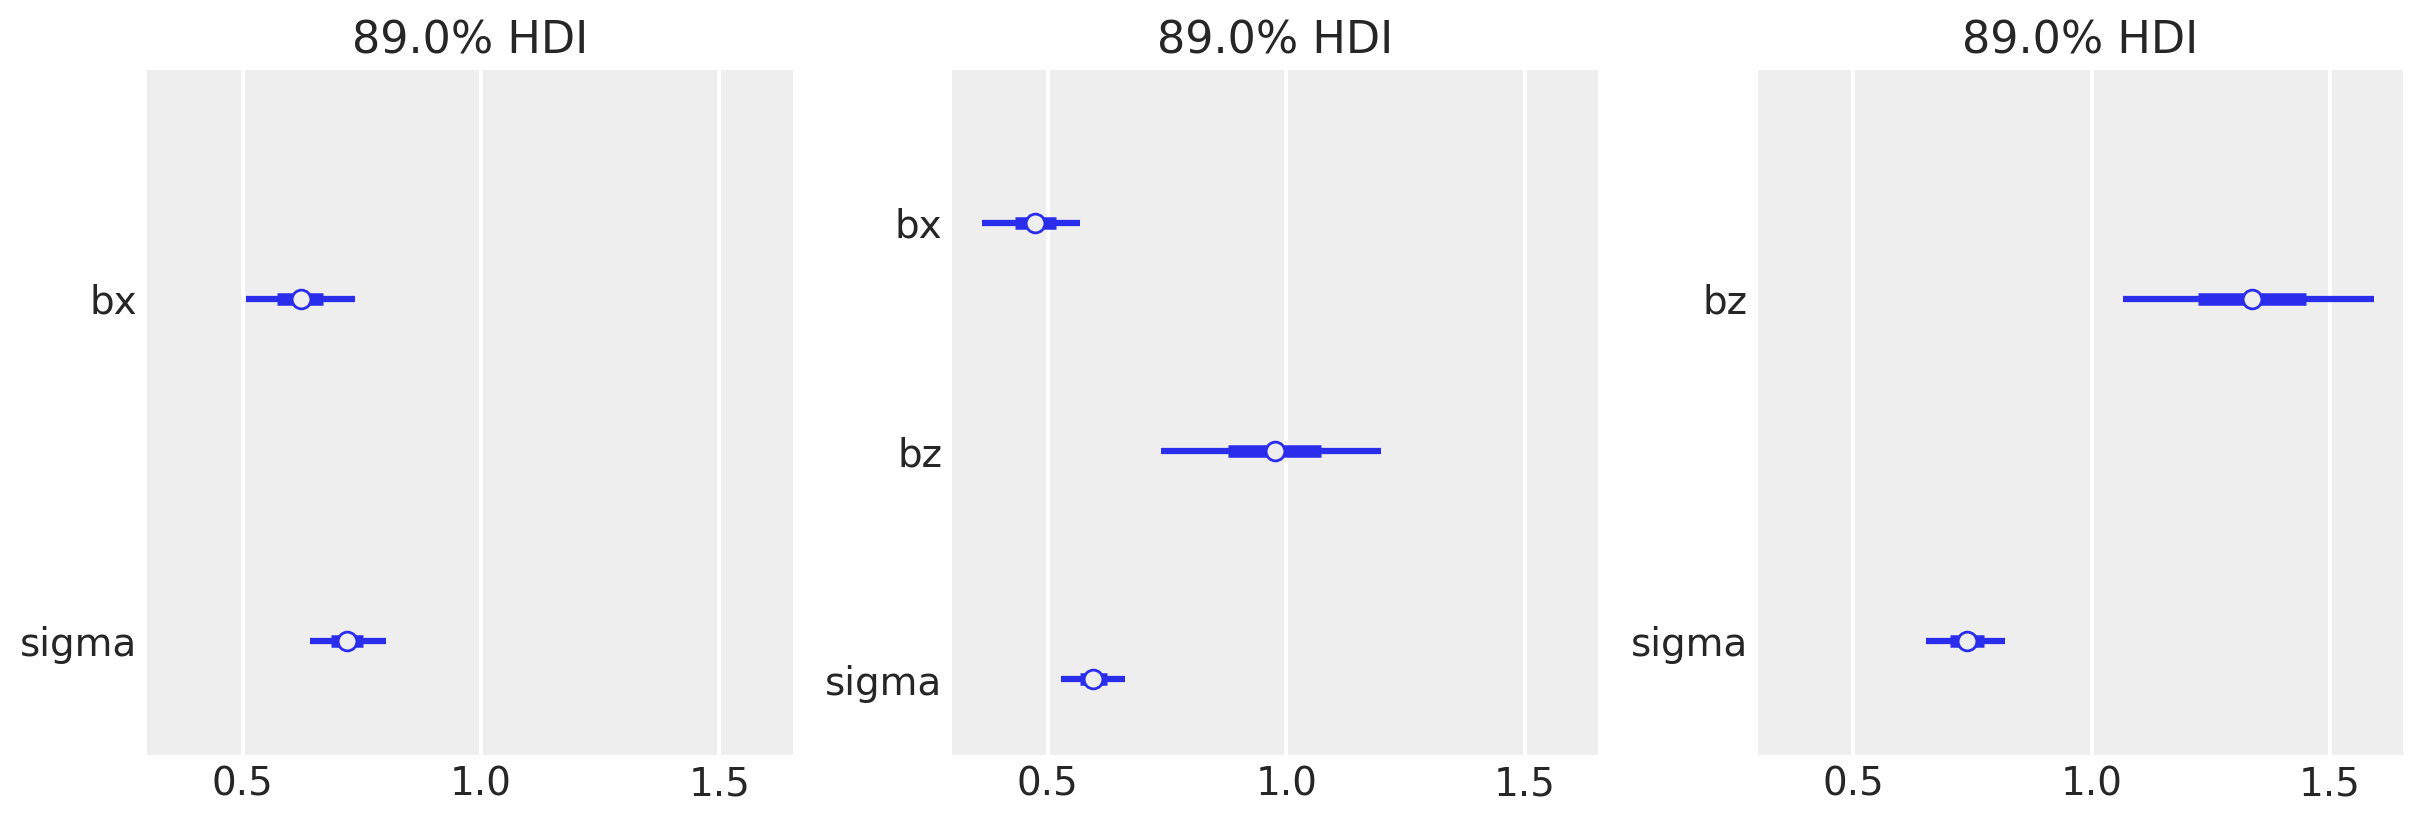

<IPython.core.display.Javascript object>

In [90]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
az.plot_forest(trace_m15m4a, combined=True, ax=ax1)
az.plot_forest(trace_m15m4b, combined=True, ax=ax2)
az.plot_forest(trace_m15m4c, combined=True, ax=ax3)

## Post with mediator, fork, collider

- have arrows pointing in different directions (X > Y > Z; X > Y < Z)
- have outcomes vary, in each condition (predict Y, predict Z, etc.)
- show how all can be correlated
- impact of sample size

## Post with binomial versus normal distributions
- variable is continuous versus categorical

## Impact of different kinds of simulations/magnitudes

Scott's R code

```
n <- 10000
x <- rnorm(n)
y <- 0.5*x+rnorm(n)
z <- 0.4*y+rnorm(n)

d <- data.frame(x,y,z)
lm(y~z+x)
lm(y~x)
```

In [71]:
n = 10**5
x = stats.norm.rvs(size=n)
y = 0.5*x + stats.norm.rvs(n)
z = 0.4*y + stats.norm.rvs(n)

df_sim2 = pd.DataFrame({"X":x, "Y":y, "Z":z})


<IPython.core.display.Javascript object>

In [72]:
sm.OLS(df_sim2['Y'], df_sim2[['X']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                            0.03933
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                       0.843
Time:                        17:04:54   Log-Likelihood:                     -1.2932e+06
No. Observations:              100000   AIC:                                  2.586e+06
Df Residuals:                   99999   BIC:                                  2.586e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X            -62.7574    316.467     -0.198      0.843    -683.028     557.513
==============================================================================
Omnibus:                        0.823   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.663   Jarque-Bera (JB):                0.826
Skew:                          -0.007   Prob(JB):                        0.662
Kurtosis:                       2.997   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [73]:
sm.OLS(df_sim2['Y'], df_sim2[['X', 'Z']]).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.964e+24
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:05:10   Log-Likelihood:             2.2187e+06
No. Observations:              100000   AIC:                        -4.437e+06
Df Residuals:                   99998   BIC:                        -4.437e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.3571   1.77e-13   2.02e+12      0.000       0.357       0.357
Z              0.7143   1.26e-18   5.65e+17      0.000       0.714       0.714
==============================================================================
Omnibus:                      777.903   Durbin-Watson:                   0.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              536.605
Skew:                          -0.047   Prob(JB):                    3.00e-117
Kurtosis:                       2.654   Cond. No.                     1.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In [77]:
with pm.Model() as m15m4_2a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # sample
    trace_m15m4_2a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

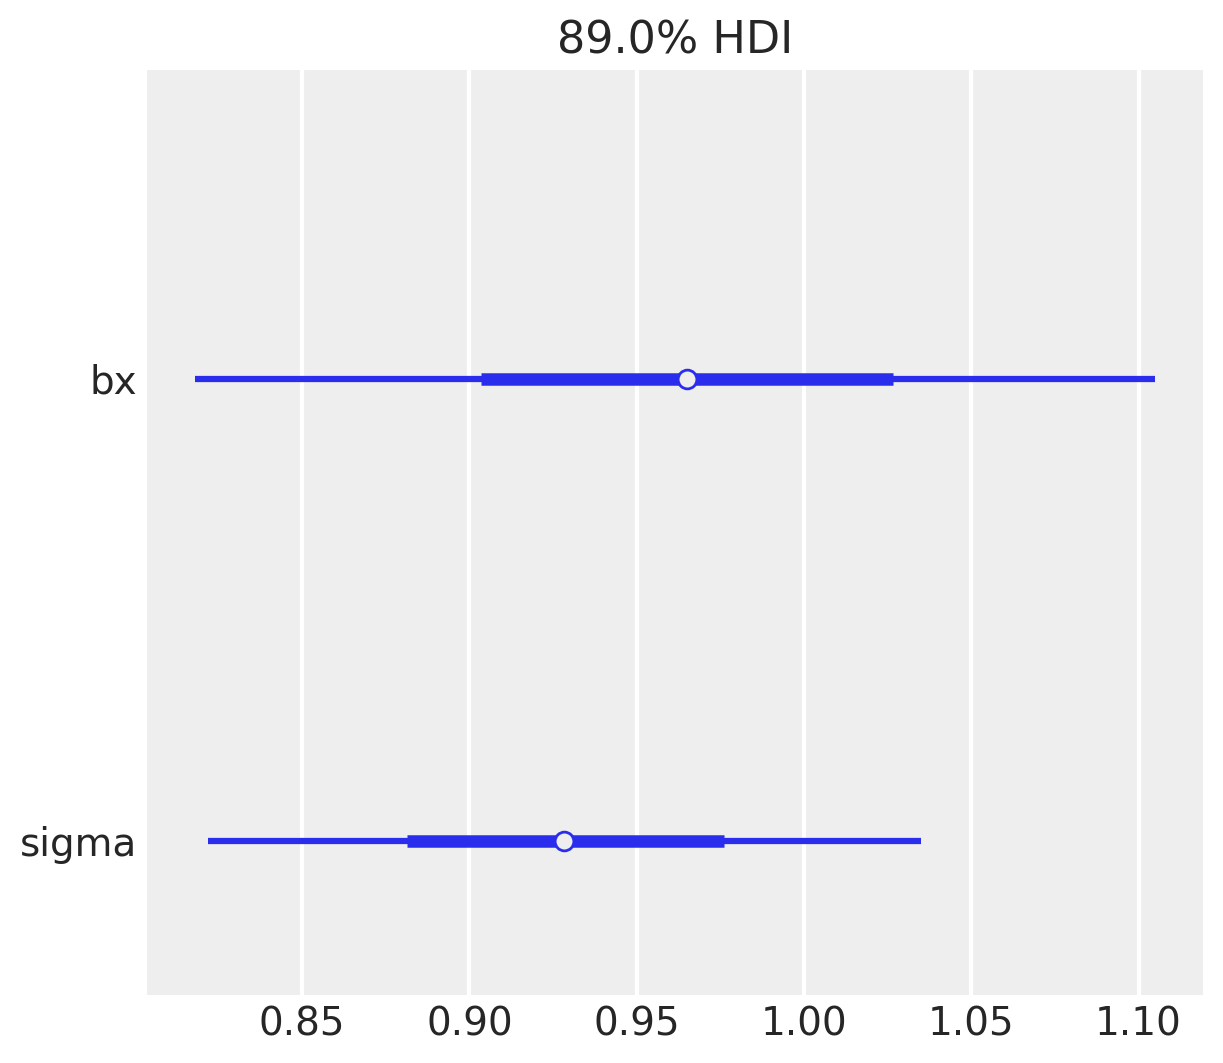

<IPython.core.display.Javascript object>

In [79]:
with pm.Model() as m15m4_2b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X'] + bz*df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # sample
    trace_m15m4_2b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

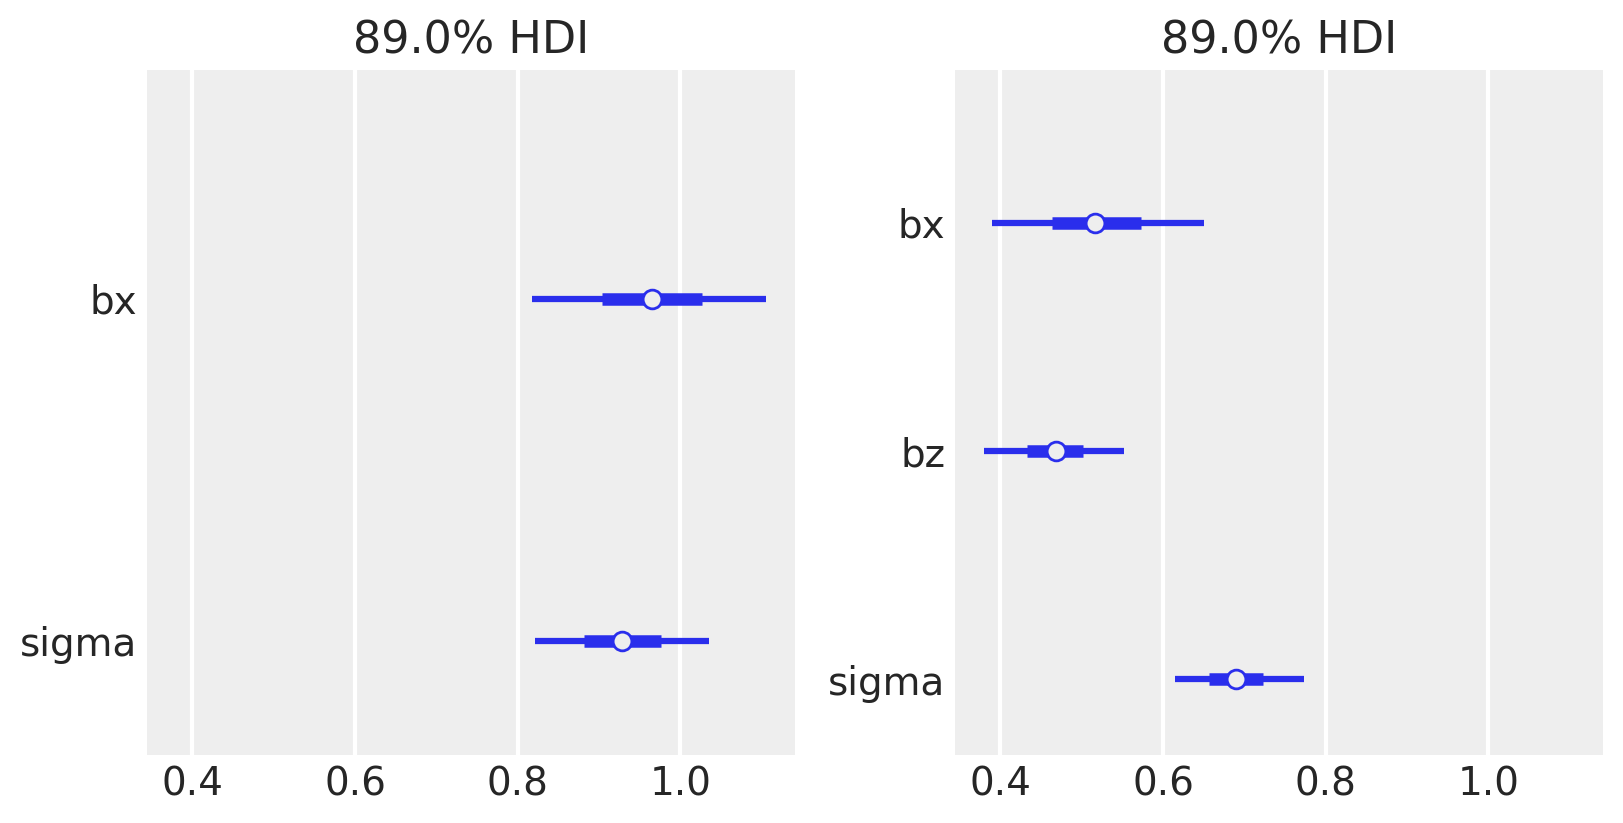

<IPython.core.display.Javascript object>

In [81]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
az.plot_forest(trace_m15m4_2a, combined=True, ax=ax1)
az.plot_forest(trace_m15m4_2b, combined=True, ax=ax2)

In [22]:
X = np.random.normal(0, 1, size=100)
Y = np.random.normal(0, 1, size=100)*X + 0.25
Z = np.random.normal(0, 1, size=100)*Y + 1

df = pd.DataFrame(np.array([X,Y,Z]).reshape(100,3))
df.columns = ['X', 'Y', 'Z']

<IPython.core.display.Javascript object>

In [ ]:
az.plot_forest(trace_m15m4b, combined=True)

In [52]:
df.iloc[:, 1:3].corr()

Y         Z
Y  1.000000  0.284929
Z  0.284929  1.000000

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


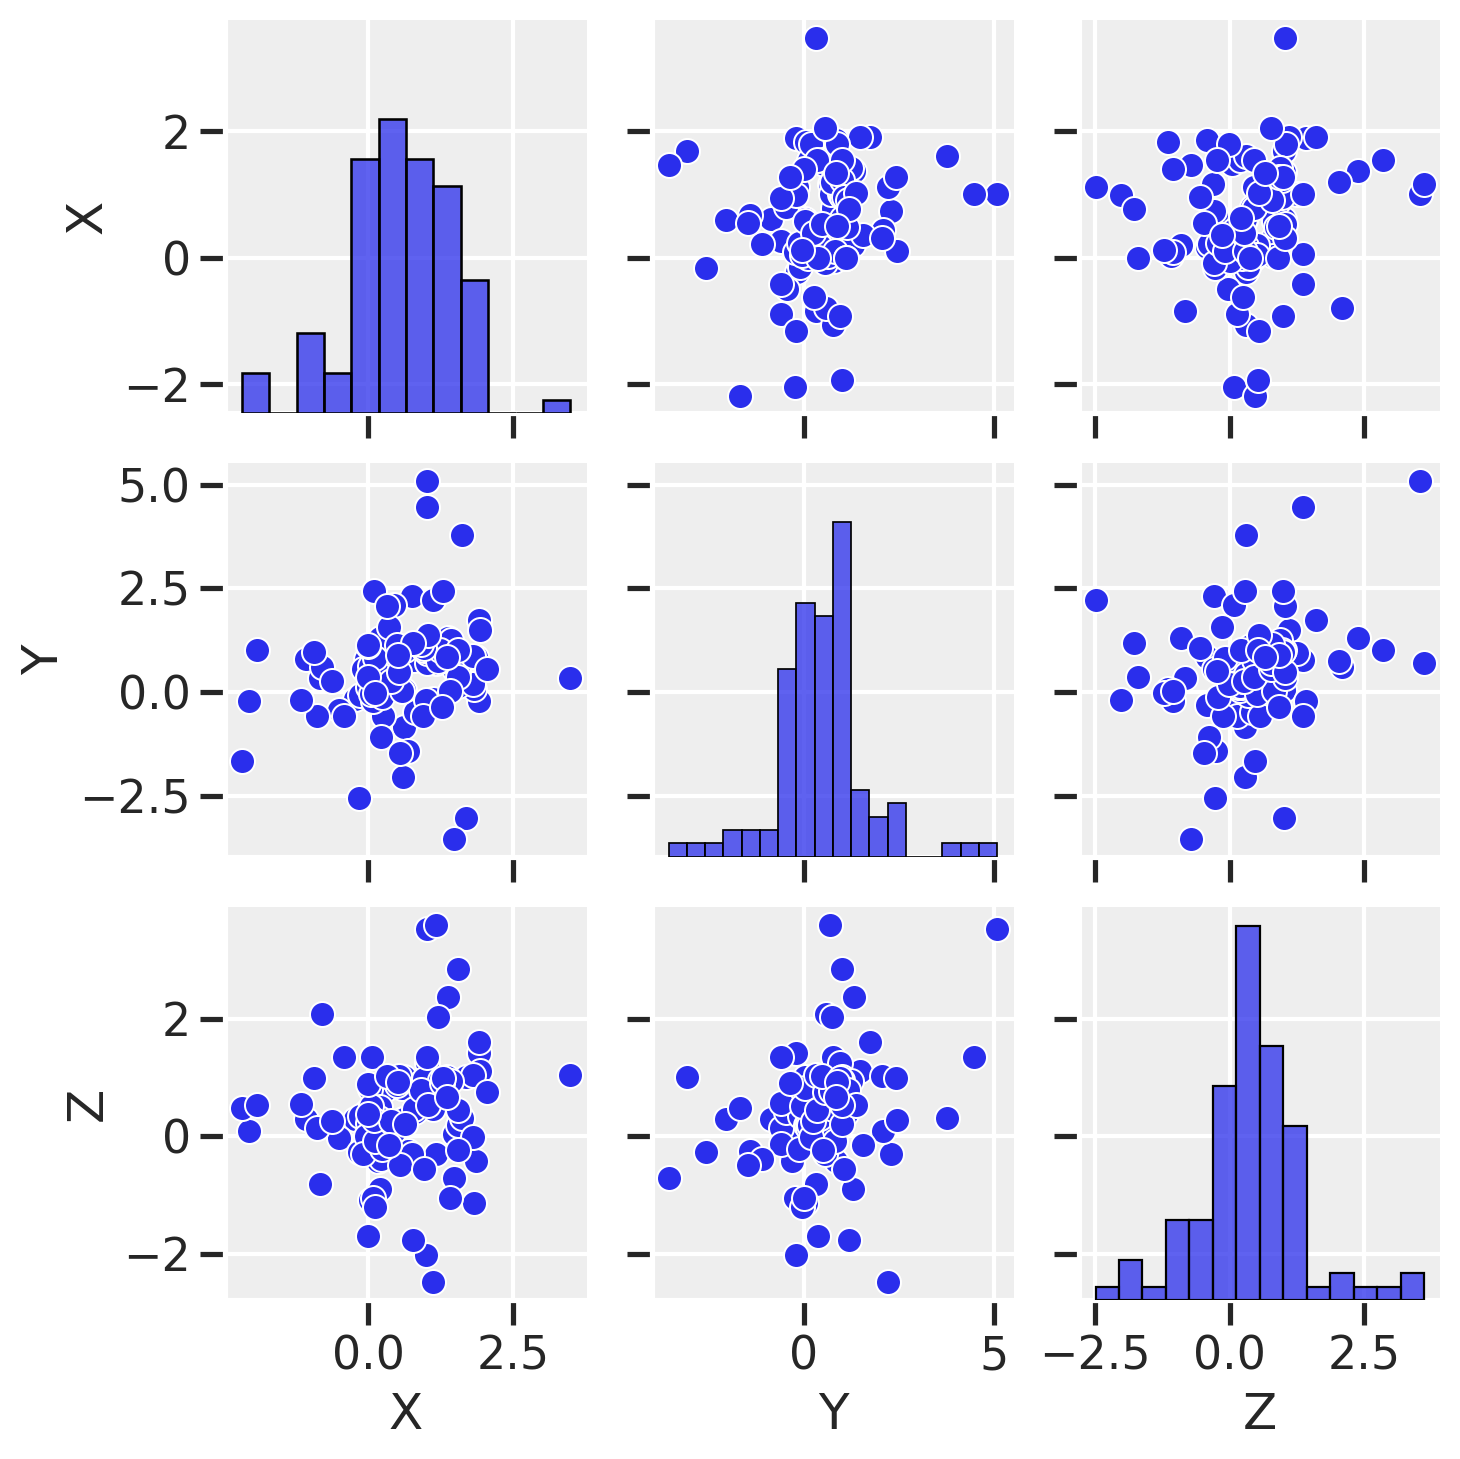

<IPython.core.display.Javascript object>

In [48]:
sns.pairplot(df)

In [ ]:
sns.

In [ ]:
with pm.Model() as m1:

    # prior
    a = pm.Normal()


    # likelihood?


    

### Simulation from McElreath's causal salad lecture

McElreath's [causal salad](https://github.com/rmcelreath/causal_salad_2021/blob/main/1_causal_salad.r) example.

In [ ]:
# 

## Back to Section 3.3

I still didn't understand above, so he explitly goes over simulation to simulate prediction here.

In [53]:
from scipy.stats import binom

<IPython.core.display.Javascript object>

Probability of observing 0, 1, 2 water for three tosses of the globe.

In [126]:
# dbinom( 0:2,size=2,prob=0.7)
# n = tosses of the globe
# k = list of desired observations (range(3)) is 0,1,2
stats.binom.pmf(k=[0,1,2], n=2, p=0.7)


array([0.09, 0.42, 0.49])

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [3]:
%watermark -n -u -v -iv -w

UsageError: Line magic function `%watermark` not found.
